In [96]:
import os

import matplotlib.pyplot as plt
import gc
import numpy as np
import nibabel as nib
import statsmodels.api as sm                                                                                        
from os.path import join as pjoin
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import zscore
from joblib import Parallel, delayed
import joblib
import time
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from utils import train_data_normalization, Timer, net_size_info, conv2_labels

In [2]:
# path settings
work_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/'
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
# input path
resp_path = pjoin(work_dir, 'prep/brain_response')
voxel_mask_path = pjoin(work_dir, 'prep/voxel_masks')
image_activations_path = pjoin(work_dir, 'prep/image_activations')
concate_feature_path = pjoin(work_dir, 'prep/concate_features')
retino_path = pjoin(work_dir, 'build/retinoparams')
guass_path = pjoin(work_dir, 'build/gaussianparams')
avgrf_path = pjoin(work_dir, 'prep/image_mask')
# save out path
performance_path = pjoin(work_dir, 'build/lasso-feature-withinsub-concatevoxels/')

# Performance check
- 比较 concate 和 平均 的 performance

In [50]:
concate_model_path = pjoin(work_dir, 'build/lasso-feature-withinsub-concatevoxels')
average_model_path = pjoin(work_dir, 'build/lasso-feature-selection')

concate_linear_models = sorted([_ for _ in os.listdir(pjoin(concate_model_path, 'V1')) if 'linear' in _])
concate_lasso_models = sorted([_ for _ in os.listdir(pjoin(concate_model_path, 'V1')) if 'lasso' in _])

average_linear_models = sorted([_ for _ in os.listdir(pjoin(average_model_path, 'linear-dnnRF')) if 'linear.pkl' in _])
average_lasso_models = sorted([_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if 'lasso.pkl' in _])

files = ['valcorrfile', 'valevfile', 'testcorrfile', 'testevfile']

concate_trans = {'valcorrfile':'validation-corr', 'valevfile':'validation-expvar',
                 'testcorrfile': 'test-corr', 'testevfile': 'test-expvar'}

avg_trans = {'valcorrfile':'val-corr', 'valevfile':'val-expvar',
                 'testcorrfile': 'test-corr', 'testevfile': 'test-expvar'}


concate_linear_performance = {}
for file in files:
    perf_file = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'linear' in _ and concate_trans[file] in _][0]
    perf_file = pjoin(concate_model_path, perf_file)
    concate_linear_performance[file] = perf_file

concate_lasso_performance = {}
for file in files:
    perf_file = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'lasso' in _ and concate_trans[file] in _][0]
    perf_file = pjoin(concate_model_path, perf_file)
    concate_lasso_performance[file] = perf_file

avg_lasso_performance = {}
for file in files:
    perf_file = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if avg_trans[file] in _][0]
    perf_file = pjoin(average_model_path, 'lasso-dnnRF', perf_file)
    avg_lasso_performance[file] = perf_file

avg_linear_performance = {}
for file in files:
    perf_file = [_ for _ in os.listdir(pjoin(average_model_path, 'linear-dnnRF')) if avg_trans[file] in _][0]
    perf_file = pjoin(average_model_path, 'linear-dnnRF', perf_file)
    avg_linear_performance[file] = perf_file


In [63]:
modelperf_dict = [concate_linear_performance, concate_lasso_performance, avg_linear_performance, avg_lasso_performance]
corr_files = ['valcorrfile', 'testcorrfile']
ev_files = ['valevfile', 'testevfile']

val_corr = []
for modelperf in modelperf_dict:
    val_corr.append(np.load(pjoin(modelperf['valcorrfile'])))

tst_corr = []
for modelperf in modelperf_dict:
    tst_corr.append(np.load(pjoin(modelperf['testcorrfile'])))

In [64]:
np.array(tst_corr).mean(axis=1)

array([0.22898118, 0.22859475, 0.25395791, 0.26235133])

In [83]:
from scipy import stats
# 假设这是两组配对的样本数据
fisher_z = lambda r : 0.5 * np.log((1 + r) / (1 - r))
data1 = fisher_z(val_corr[0])
data2 = fisher_z(val_corr[1])

# 进行配对样本t检验
t_stat, p_value = stats.ttest_rel(data1, data2)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

T-statistic: -5.337767973007302
P-value: 0.0006959990966116424


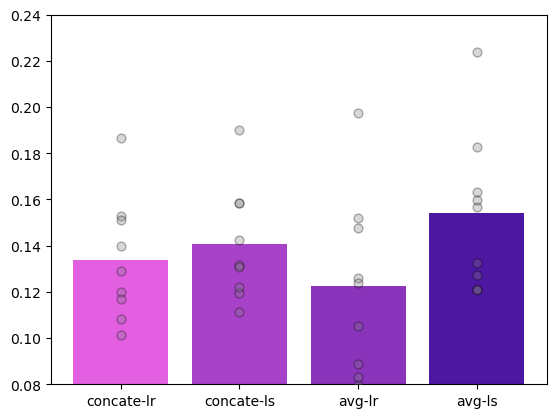

In [85]:
colors = ["#e25fe2","#a742c8","#8934bb","#4e17a1"]
plt.bar([0,1,2,3], np.array(val_corr).mean(axis=1), color=colors)

for i in range(4):
    plt.scatter([i]*len(val_corr[i]), val_corr[i], color='grey', s=40, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
plt.xticks([0,1,2,3], ['concate-lr', 'concate-ls', 'avg-lr', 'avg-ls'])
plt.ylim([0.08,0.24])
plt.show()

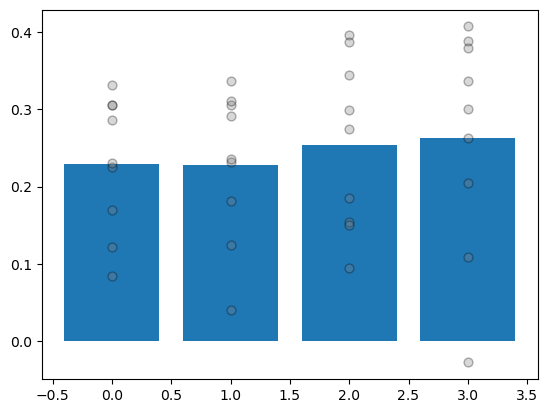

In [66]:
plt.bar([0,1,2,3], np.array(tst_corr).mean(axis=1))
for i in range(4):
    plt.scatter([i]*len(tst_corr[i]), tst_corr[i], color='grey', s=40, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)

In [150]:
lrcor = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/all-sub_model-linear_V1_test-corr.npy')
lrvalcor = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/all-sub_model-linear_V1_validation-corr.npy')

nsdlrcor = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/build/lasso-feature-withinsub-concatevoxels/all-sub_model-linear_V1_test-corr.npy')
nsdvalcor = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/build/lasso-feature-withinsub-concatevoxels/all-sub_model-linear_V1_validation-corr.npy')


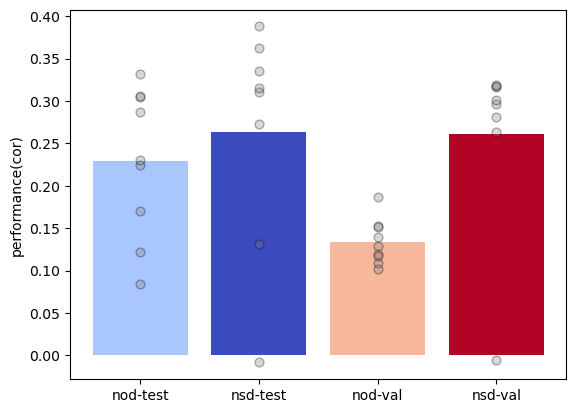

In [163]:
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
colors = [colors[1], colors[0], colors[2], colors[3]]
plt.bar([0,1,2,3], [lrcor.mean(), nsdlrcor.mean(), lrvalcor.mean(), nsdvalcor.mean()],  color=colors)

plt.scatter([0]*len(lrcor), lrcor, color='grey', s=40, 
                edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
plt.scatter([1]*len(nsdlrcor), nsdlrcor, color='grey', s=40, 
                edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
plt.scatter([2]*len(lrvalcor), lrvalcor, color='grey', s=40, 
                edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
plt.scatter([3]*len(nsdvalcor), nsdvalcor, color='grey', s=40, 
                edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
plt.xticks([0,1,2,3], ['nod-test', 'nsd-test', 'nod-val', 'nsd-val'])
plt.ylabel('performance(cor)')
plt.show()

In [53]:
lasso = joblib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/V1/sub-01_lasso.pkl')

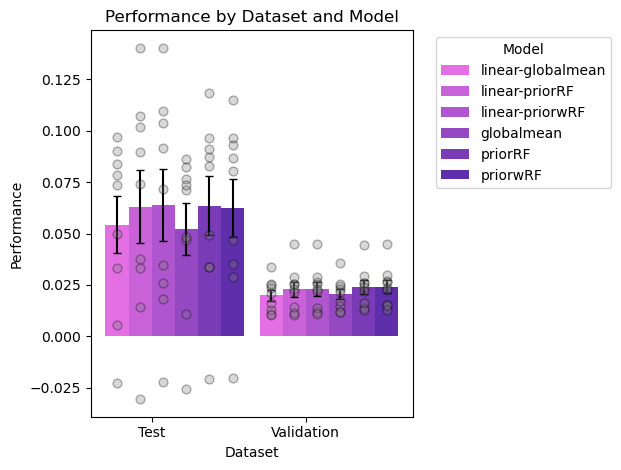

In [41]:
# 分指标作图
model_types = os.listdir(performance_path)

# 定义模型文件夹名称
model_folders = ['linear-globalmean', 'linear-priorRF', 'linear-priorwRF', 'globalmean', 'priorRF', 'priorwRF']

datasets = ['Test', 'Validation']
model_colors = ["#e25fe2","#c451d5","#a742c8","#8934bb","#6c25ae","#4e17a1"]

# 初始化数据存储结构
test_performances = []
validation_performances = []

# 遍历每个模型，读取测试集和验证集表现
for folder in model_folders:
    # test_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_test-corr.npy')
    # validation_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_validation-corr.npy')

    test_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_test-expvar.npy')
    validation_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_validation-expvar.npy')

    if np.load(test_path).ndim==3:
        test_cor = np.array([ np.load(test_path)[_][0,1] for _ in range(9)])
    else:
        test_cor = np.load(test_path)

    if np.load(validation_path).ndim==3:
        validation_cor = np.array([np.load(validation_path)[_][0,1] for _ in range(9)])
    else:
        validation_cor = np.load(validation_path)

    test_performances.append(test_cor)
    validation_performances.append(validation_cor)


plt.style.use('default')
# 准备绘图数据
n_groups = len(model_folders)
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

fig, ax = plt.subplots()
dataset_indices = np.arange(2)  # 数据集数量，这里有两个：测试集和验证集
bar_width = 0.15

# 对于测试集和验证集分别绘制四个模型的性能
for i, model_perf in enumerate(test_performances):
    # 计算每个模型的平均性能和标准误
    means = [np.mean(test_performances[i]), np.mean(validation_performances[i])]
    sems = [np.std(test_performances[i], ddof=1) / np.sqrt(len(test_performances[i])), 
            np.std(validation_performances[i], ddof=1) / np.sqrt(len(validation_performances[i]))]
    
    # 绘制柱状图
    rects = ax.bar(dataset_indices + i*bar_width, means, bar_width, yerr=sems, label=model_folders[i],
                   capsize=3, color=model_colors[i], alpha=0.9)
    
    # 在柱状图上添加原始性能数据点
    for idx, perf in enumerate([test_performances[i], validation_performances[i]]):
        ax.scatter(np.ones_like(perf) * (dataset_indices[idx] + i*bar_width), perf, color='grey', s=40, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)

# 添加图表细节
ax.set_xlabel('Dataset')
ax.set_ylabel('Performance')
ax.set_title('Performance by Dataset and Model')
ax.set_xticks(dataset_indices + bar_width*1.5)
ax.set_xticklabels(['Test', 'Validation'])
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [44]:
sorted(os.listdir(performance_path))

['globalmean-crsub-ls-wnsub-lr-N',
 'globalmean-crsub-ls-wnsub-lr-U',
 'linear-globalmean',
 'linear-priorRF',
 'linear-priorwRF',
 'priorRF-crsub-ls-wnsub-lr-N',
 'priorRF-crsub-ls-wnsub-lr-U',
 'priorwRF-crsub-ls-wnsub-lr-N',
 'priorwRF-crsub-ls-wnsub-lr-U']

In [57]:
model_types = os.listdir(performance_path)

# 定义模型文件夹名称
model_folders = ['linear-globalmean', 'linear-priorRF', 'linear-priorwRF', \
                'globalmean-crsub-ls-wnsub-lr-N', 'priorRF-crsub-ls-wnsub-lr-N', 'priorwRF-crsub-ls-wnsub-lr-N', \
                'globalmean-crsub-ls-wnsub-lr-U', 'priorRF-crsub-ls-wnsub-lr-U',  'priorwRF-crsub-ls-wnsub-lr-U' ]

feature_select = ['Null', 'lasso-Union', 'lasso-iNtersect']
model_colors = ["#ff6361","#ff8531","#ffa600"]

# 初始化数据存储结构
test_performances = []

# 遍历每个模型，读取测试集和验证集表现
for folder in model_folders:
    test_path = os.path.join(performance_path, folder, f'nod-within-sub_model-{folder}_val-corr.npy')

    # test_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_test-expvar.npy')
    # validation_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_validation-expvar.npy')

    if np.load(test_path).ndim==3:
        test_cor = np.array([ np.load(test_path)[_][0,1] for _ in range(9)])
    else:
        test_cor = np.load(test_path)

    test_performances.append(test_cor)

# test_performances

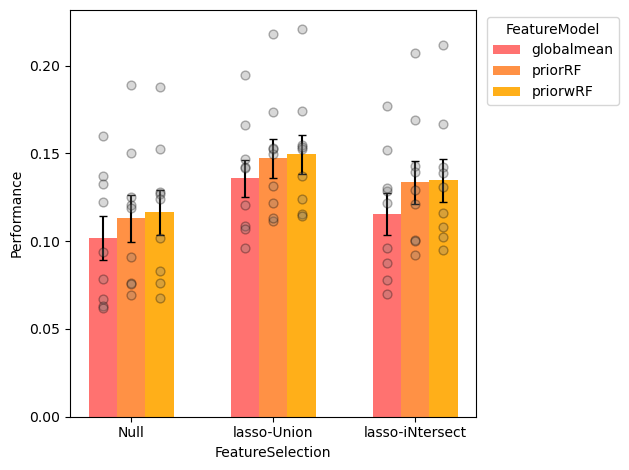

In [61]:
plt.style.use('default')
# 准备绘图数据
opacity = 0.8
featurenames = ['globalmean', 'priorRF', 'priorwRF']
fig, ax = plt.subplots()
dataset_indices = np.arange(2)  # 数据集数量，这里有两个：测试集和验证集
bar_width = 0.2

model_xs = [-0.2,0,0.2, 0.8,1,1.2, 1.8,2,2.2]

# 对于测试集和验证集分别绘制四个模型的性能
for i, model_perf in enumerate(test_performances):
    # 计算每个模型的平均性能和标准误
    means = np.mean(test_performances[i])
    sems = np.std(test_performances[i], ddof=1) / np.sqrt(len(test_performances[i]))
    
    # 绘制柱状图
    if i<3 :
        rects = ax.bar(model_xs[i], means, bar_width, yerr=sems, capsize=3, color=model_colors[i%3], label=featurenames[i%3],alpha=0.9)
    else:
        rects = ax.bar(model_xs[i], means, bar_width, yerr=sems, capsize=3, color=model_colors[i%3],alpha=0.9)
    # 在柱状图上添加原始性能数据点
    ax.scatter(np.ones_like(model_perf) * (model_xs[i]), model_perf, color='grey', s=40, 
                edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
        

# 添加图表细节
ax.set_xlabel('FeatureSelection')
ax.set_ylabel('Performance')
# ax.set_title('Performance by Dataset and Model')
ax.set_xticks([0,1,2])
ax.set_xticklabels(feature_select)
ax.legend(title='FeatureModel', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [74]:
gm_n_file = pjoin(performance_path, 'globalmean-crsub-ls-wnsub-lr-N/nod-cross-sub_model-globalmean-crsub-ls-wnsub-lr-N_features-intersection.npy')
gm_u_file = pjoin(performance_path, 'globalmean-crsub-ls-wnsub-lr-N/nod-cross-sub_model-globalmean-crsub-ls-wnsub-lr-N_features-union.npy')
rf_n_file = pjoin(performance_path, 'priorRF-crsub-ls-wnsub-lr-N/nod-cross-sub_model-priorRF-crsub-ls-wnsub-lr-N_features-intersection.npy')
rf_u_file = pjoin(performance_path, 'priorRF-crsub-ls-wnsub-lr-N/nod-cross-sub_model-priorRF-crsub-ls-wnsub-lr-N_features-union.npy')
wrf_n_file = pjoin(performance_path, 'priorwRF-crsub-ls-wnsub-lr-N/nod-cross-sub_model-priorwRF-crsub-ls-wnsub-lr-N_features-intersection.npy')
wrf_u_file = pjoin(performance_path, 'priorwRF-crsub-ls-wnsub-lr-N/nod-cross-sub_model-priorwRF-crsub-ls-wnsub-lr-N_features-union.npy')

gm_n = np.load(gm_n_file)
gm_u = np.load(gm_u_file)
rf_n = np.load(rf_n_file)
rf_u = np.load(rf_u_file)
wrf_n = np.load(wrf_n_file)
wrf_u = np.load(wrf_u_file)

filter_path = pjoin(work_dir, 'prep/feature_filters')

np.save(pjoin(filter_path, 'globalmean-union.npy'), gm_u)
np.save(pjoin(filter_path, 'globalmean-inter.npy'), gm_n)
np.save(pjoin(filter_path, 'priorRF-union.npy'), rf_u)
np.save(pjoin(filter_path, 'priorRF-inter.npy'), rf_n)
np.save(pjoin(filter_path, 'priorwRF-union.npy'), wrf_u)
np.save(pjoin(filter_path, 'priorwRF-inter.npy'), wrf_n)

In [71]:
np.load(pjoin(performance_path, 'globalmean-crsub-ls-wnsub-lr-U/nod-cross-sub_model-globalmean-crsub-ls-wnsub-lr-U_features-union.npy'))

array([ 0,  1,  3,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 24, 26, 27,
       28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 45, 48, 49, 51, 52,
       58, 60])

In [73]:
gm_u

array([ 0,  1,  3,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19, 21, 24, 26, 27,
       28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 45, 48, 49, 51, 52,
       58, 60])

In [70]:
len(set(gm_n) | set(rf_n) | set( wrf_n)), len(gm_n), len(rf_n), len(wrf_n)
len(set(rf_n) | set( wrf_n))

13

In [68]:

len(set(gm_u)| set(rf_u) | set( wrf_u)), len(gm_u), len(rf_u), len(wrf_u)

(44, 36, 35, 34)

In [29]:
import joblib
model = joblib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-selection/linear/nod-cross-sub_model-priorwRF_linear.pkl')


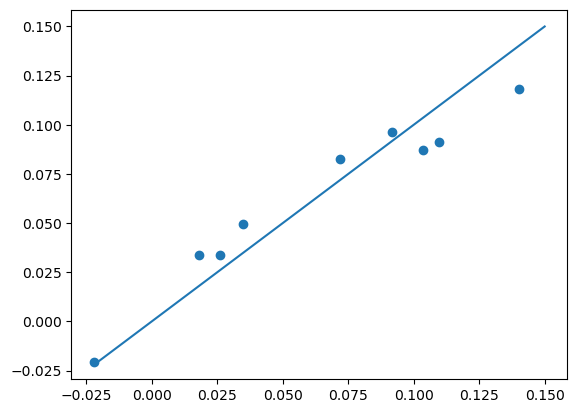

In [33]:
plt.scatter(test_performances[1], test_performances[2])
plt.plot([-0.02, 0.15], [-0.02,0.15])

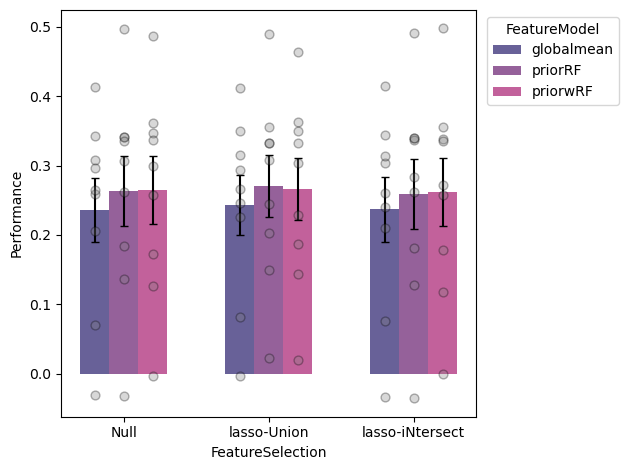

In [39]:
model_types = os.listdir(performance_path)

# 定义模型文件夹名称
model_folders = ['lasso-globalmean', 'lasso-priorRF', 'lasso-priorwRF', \
                'globalmean-crsub-ls-wnsub-ls-N', 'priorRF-crsub-ls-wnsub-ls-N', 'priorwRF-crsub-ls-wnsub-ls-N', \
                'globalmean-crsub-ls-wnsub-ls-U', 'priorRF-crsub-ls-wnsub-ls-U',  'priorwRF-crsub-ls-wnsub-ls-U' ]

feature_select = ['Null', 'lasso-Union', 'lasso-iNtersect']
model_colors = ["#58508d","#8a508f","#bc5090"]

# 初始化数据存储结构
test_performances = []

# 遍历每个模型，读取测试集和验证集表现
for folder in model_folders:
    # test_path = os.path.join(performance_path, folder, f'nod-within-sub_model-{folder}_val-corr.npy')


    test_path = os.path.join(performance_path, folder, f'nod-within-sub_model-{folder}_test-corr.npy')
    # validation_path = os.path.join(performance_path, folder, f'nod-cross-sub_model-{folder}_validation-expvar.npy')

    if np.load(test_path).ndim==3:
        test_cor = np.array([ np.load(test_path)[_][0,1] for _ in range(9)])
    else:
        test_cor = np.load(test_path)

    test_performances.append(test_cor)

plt.style.use('default')
# 准备绘图数据
opacity = 0.8
featurenames = ['globalmean', 'priorRF', 'priorwRF']
fig, ax = plt.subplots()
dataset_indices = np.arange(2)  # 数据集数量，这里有两个：测试集和验证集
bar_width = 0.2

model_xs = [-0.2,0,0.2, 0.8,1,1.2, 1.8,2,2.2]

# 对于测试集和验证集分别绘制四个模型的性能
for i, model_perf in enumerate(test_performances):
    # 计算每个模型的平均性能和标准误
    means = np.mean(test_performances[i])
    sems = np.std(test_performances[i], ddof=1) / np.sqrt(len(test_performances[i]))
    
    # 绘制柱状图
    if i<3 :
        rects = ax.bar(model_xs[i], means, bar_width, yerr=sems, capsize=3, color=model_colors[i%3], label=featurenames[i%3],alpha=0.9)
    else:
        rects = ax.bar(model_xs[i], means, bar_width, yerr=sems, capsize=3, color=model_colors[i%3],alpha=0.9)
    # 在柱状图上添加原始性能数据点
    ax.scatter(np.ones_like(model_perf) * (model_xs[i]), model_perf, color='grey', s=40, 
                edgecolor='black', linewidth=1., alpha=0.3, zorder=3)
        

# 添加图表细节
ax.set_xlabel('FeatureSelection')
ax.set_ylabel('Performance')
# ax.set_title('Performance by Dataset and Model')
ax.set_xticks([0,1,2])
ax.set_xticklabels(feature_select)
ax.legend(title='FeatureModel', bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Lasso Non-Zero parameter check
- 

In [82]:
res_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-selection'
modelname = 'lasso-priorRF'
models = sorted([_ for _ in os.listdir(pjoin(res_dir, modelname)) if '.pkl' in _])

for model in models:
    
    lasso = joblib.load(pjoin(res_dir, modelname, model))
    print(model.split('_')[0], ':', np.where(lasso.coef_!=0)[0], f'({len(np.where(lasso.coef_!=0)[0])})')

nod-within-sub-1 : [ 9 13 33 34 39 45 46 47 49 56] (10)
nod-within-sub-2 : [ 1  9 11 15 16 23 28 32 40 42 45 46 48 49] (14)
nod-within-sub-3 : [ 1  3  8  9 10 11 17 21 26 29 31 38 46 47 48 52 55 61] (18)
nod-within-sub-4 : [ 9 16 28 33 41 42 60] (7)
nod-within-sub-5 : [ 5  9 28 33 34 38 42 44] (8)
nod-within-sub-6 : [ 1  5 10 21 26 28 33 34 40 41 44 49 52 58] (14)
nod-within-sub-7 : [ 9 13 16 24 25 28 39 45 46 49 56] (11)
nod-within-sub-8 : [ 9 13 15 16 24 31 33 34 38 40 43 44 45 53] (14)
nod-within-sub-9 : [ 6 12 28 45 62] (5)


In [97]:
res_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-selection'
modelname = 'lasso-globalmean'
models = sorted([_ for _ in os.listdir(pjoin(res_dir, modelname)) if '.pkl' in _])

for model in models:
    
    lasso = joblib.load(pjoin(res_dir, modelname, model))
    print(model.split('_')[0], ':', np.where(lasso.coef_!=0)[0], f'({len(np.where(lasso.coef_!=0)[0])})')

nod-within-sub-1 : [ 9 13 31 45 46 49] (6)
nod-within-sub-2 : [ 1  9 10 11 14 16 23 32 45 46] (10)
nod-within-sub-3 : [ 1  9 10 17 21 26 27 30 32 38 46 47 52 55 58] (15)
nod-within-sub-4 : [ 9 10 16 24 31 33 40 41] (8)
nod-within-sub-5 : [ 1  9 27 28 34 38 39 48] (8)
nod-within-sub-6 : [ 1 10 21 24 26 28 33 40 44] (9)
nod-within-sub-7 : [ 9 11 16 24 32 42 44 45 48 49 55 56] (12)
nod-within-sub-8 : [ 9 13 32 34 38 40 44] (7)
nod-within-sub-9 : [ 1  2  6  9 20 39 45 46 57] (9)


In [84]:
modelname = 'priorRF-crsub-ls-wnsub-ls-N'
models = sorted([_ for _ in os.listdir(pjoin(res_dir, modelname)) if '.pkl' in _])
feature_filter = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/feature_filters/priorRF-inter.npy') 
for model in models:
    lasso = joblib.load(pjoin(res_dir, modelname, model))
    print(model.split('_')[0], ':', feature_filter[np.where(lasso.coef_!=0)[0]], f'({len(np.where(lasso.coef_!=0)[0])})')

nod-within-sub-1 : [ 9 19 28 33 34 40 45] (7)
nod-within-sub-2 : [ 1  9 10 16 19 28 34 40 45] (9)
nod-within-sub-3 : [ 1  9 10 16 19 26 34 40 45 58] (10)
nod-within-sub-4 : [ 9 16 19 28 33 40 45] (7)
nod-within-sub-5 : [ 1  9 19 28 33 34] (6)
nod-within-sub-6 : [ 1  9 10 26 28 33 34 40] (8)
nod-within-sub-7 : [ 9 16 28 45] (4)
nod-within-sub-8 : [ 9 16 26 28 33 34 40 45] (8)
nod-within-sub-9 : [ 1  9 10 16 19 26 28 33 40 45 58] (11)


In [86]:
modelname = 'priorRF-crsub-ls-wnsub-ls-U'
models = sorted([_ for _ in os.listdir(pjoin(res_dir, modelname)) if '.pkl' in _])
feature_filter = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/feature_filters/priorRF-union.npy') 
for model in models:
    lasso = joblib.load(pjoin(res_dir, modelname, model))
    print(model.split('_')[0], ':', feature_filter[np.where(lasso.coef_!=0)[0]], f'({len(np.where(lasso.coef_!=0)[0])})')

nod-within-sub-1 : [ 9 13 33 34 39 45 46 49] (8)
nod-within-sub-2 : [ 1  9 11 15 16 23 28 32 40 42 45 46 48 49] (14)
nod-within-sub-3 : [ 1  9 10 11 13 16 17 21 23 24 26 32 34 38 45 46 48 52 55 58] (20)
nod-within-sub-4 : [ 9 16 28 33 41 42] (6)
nod-within-sub-5 : [ 9 19 21 28 33 34 38 39 60] (9)
nod-within-sub-6 : [ 1 10 11 16 19 21 23 26 28 32 34 38 40 41 45 46 49 52 58 60] (20)
nod-within-sub-7 : [ 9 13 16 24 28 39 45 46 49] (9)
nod-within-sub-8 : [ 9 13 15 16 24 27 32 34 36 38 40 45] (12)
nod-within-sub-9 : [ 9 24 28 39 45] (5)


## 以下画的是被试内，将所有体素拼接在一起，经过 cross session generalization training

In [42]:
corr_file = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/all-sub_model-lasso_V1_test-corr.npy'
corrs = np.load(corr_file)
np.mean(corrs), corrs

(0.2285947464368725,
 array([0.04016449, 0.2319483 , 0.33631576, 0.29147354, 0.30583945,
        0.23520294, 0.18168575, 0.31064499, 0.1240775 ]))

In [69]:
path = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/V1'
subs = [f'sub-0{isub+1}' for isub in range(0, 9)]
alphas = []
for sub in subs:
    model = joblib.load(pjoin(path, f'{sub}_lasso.pkl'))
    print(sub,model.alpha)
    alphas.append(model.alpha)
print(np.mean(alphas))

sub-01 0.018957356524063752
sub-02 0.006812920690579615
sub-03 0.002154434690031882
sub-04 0.008799225435691074
sub-05 0.006812920690579615
sub-06 0.006812920690579615
sub-07 0.01467799267622069
sub-08 0.0031622776601683794
sub-09 0.01467799267622069
0.0092075601926817


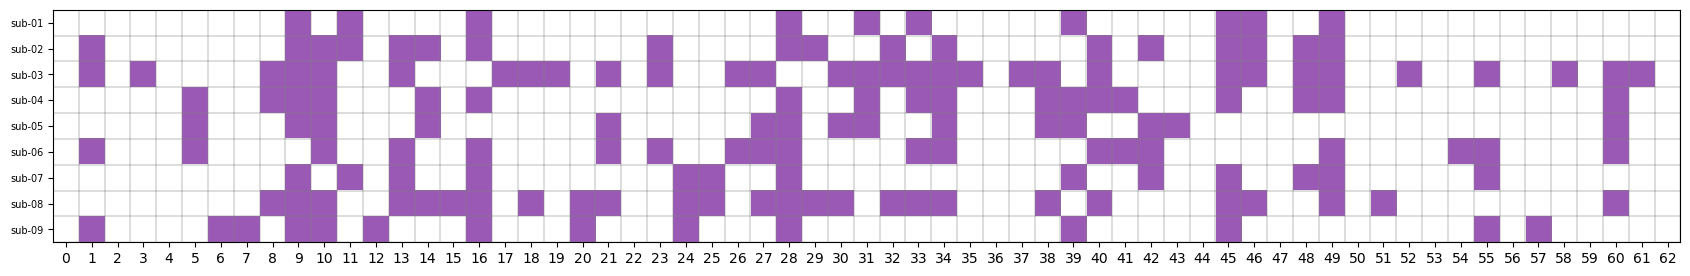

In [14]:
colors = ["white", "#cecfcf", "#9b59b6"]
# 创建自定义颜色映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

res_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels'
models = sorted([_ for _ in os.listdir(pjoin(res_dir)) if '.pkl' in _])

pmatrix = np.zeros((len(models), len(list(range(63)))))
# pmatrix[:, np.array(delete_features)] = 0.5

for isub, model in enumerate(models):
    # collect data
    lasso = joblib.load(pjoin(res_dir, model))
    pmatrix[isub, np.where(lasso.coef_!=0)[0]] = 1

plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(63))
ax.set_xticklabels(np.arange(63))
ax.set_yticks(np.arange(len(models)))
ticklabels =  [_.split('_')[0].replace('within-','') for _ in models]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()
# [0,6,4,1,3,8,9,11,10,13,14]

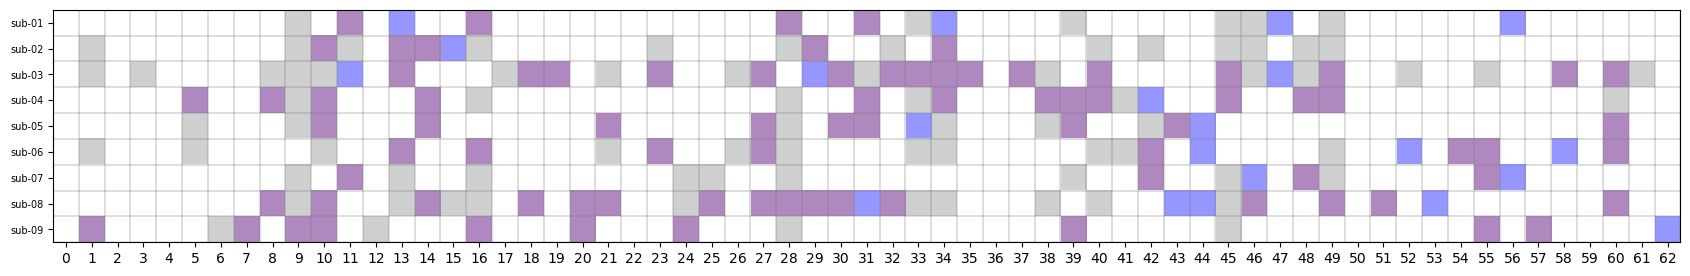

In [35]:

# 创建自定义颜色映射
meanres_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-selection'
modelname = 'lasso-priorRF'
mean_models = sorted([_ for _ in os.listdir(pjoin(meanres_dir, modelname)) if '.pkl' in _])

colors = ["white", "#5050ff", "#9b59b6", "#cecfcf"]
# 创建自定义颜色映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

res_dir = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels'
models = sorted([_ for _ in os.listdir(pjoin(res_dir)) if '.pkl' in _])

pmatrix = np.zeros((len(models), len(list(range(63)))))
# pmatrix[:, np.array(delete_features)] = 0.5

for isub, model in enumerate(models):
    # collect data
    lasso = joblib.load(pjoin(res_dir, model))
    pmatrix[isub, np.where(lasso.coef_!=0)[0]] += 0.8

for isub, mean_model in enumerate(mean_models):
    # collect data
    lasso = joblib.load(pjoin(meanres_dir, modelname, mean_model))
    pmatrix[isub, np.where(lasso.coef_!=0)[0]] += 0.2

plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(63))
ax.set_xticklabels(np.arange(63))
ax.set_yticks(np.arange(len(models)))
ticklabels =  [_.split('_')[0].replace('within-','') for _ in models]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()

## 以下画的是 平均了体素，经过 cross subject generalization training

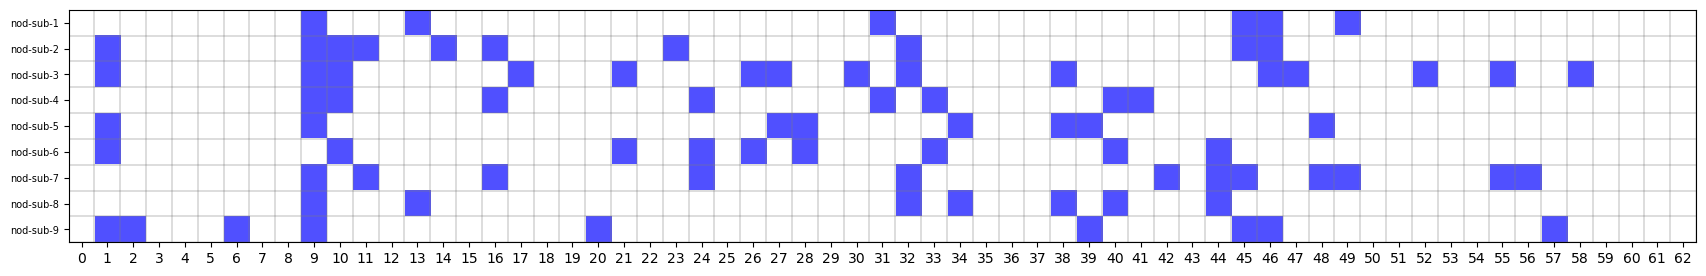

In [98]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches


colors = ["white", "#cecfcf", "#5050ff"]
# 创建自定义颜色映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

modelname = 'lasso-globalmean'
models = sorted([_ for _ in os.listdir(pjoin(res_dir, modelname)) if '.pkl' in _])

pmatrix = np.zeros((len(models), len(list(range(63)))))
# pmatrix[:, np.array(delete_features)] = 0.5

for isub, model in enumerate(models):
    # collect data
    lasso = joblib.load(pjoin(res_dir, modelname, model))
    pmatrix[isub, np.where(lasso.coef_!=0)[0]] = 1


fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(63))
ax.set_xticklabels(np.arange(63))
ax.set_yticks(np.arange(len(models)))
ticklabels =  [_.split('_')[0].replace('within-','') for _ in models]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()
# [0,6,4,1,3,8,9,11,10,13,14]

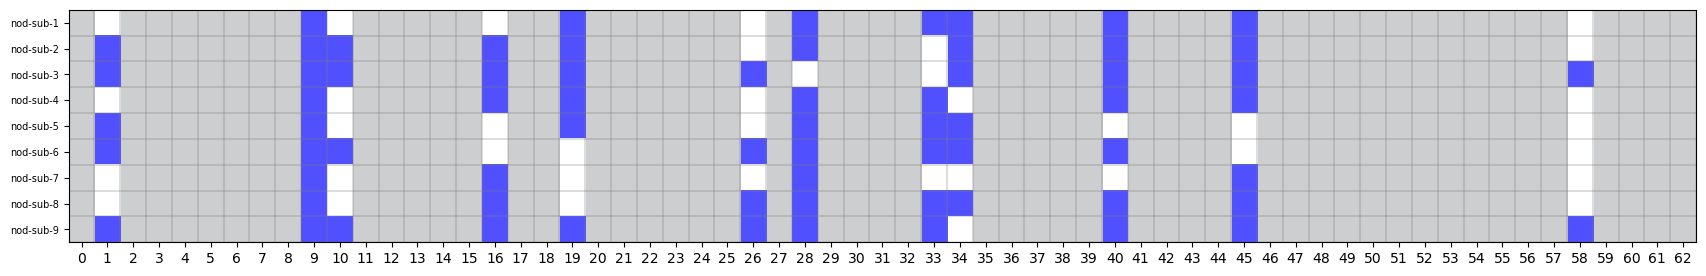

In [93]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches


colors = ["white", "#cecfcf", "#5050ff"]
# 创建自定义颜色映射
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

modelname = 'priorRF-crsub-ls-wnsub-ls-N'
models = sorted([_ for _ in os.listdir(pjoin(res_dir, modelname)) if '.pkl' in _])
if 'N' in modelname:
    feature_filter = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/feature_filters/priorRF-inter.npy') 
elif 'U' in modelname:
    feature_filter = np.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/feature_filters/priorRF-union.npy') 

delete_features  = list(set(list(range(63))) - set(feature_filter))

pmatrix = np.zeros((len(models), len(list(range(63)))))
pmatrix[:, np.array(delete_features)] = 0.5

for isub, model in enumerate(models):
    # collect data
    lasso = joblib.load(pjoin(res_dir, modelname, model))
    pmatrix[isub, feature_filter[np.where(lasso.coef_!=0)[0]]] = 1


fig, ax = plt.subplots(1, 1, figsize=(21,5))
# matrix show
ax.imshow(pmatrix, cmap=cmap)
ax.set_xticks(np.arange(63))
ax.set_xticklabels(np.arange(63))
ax.set_yticks(np.arange(len(models)))
ticklabels =  [_.split('_')[0].replace('within-','') for _ in models]
ax.set_yticklabels(ticklabels, fontsize=7)
# 获取单元格的数量
numrows, numcols = pmatrix.shape
# 为每个单元格添加边框
for x in range(numcols):
    for y in range(numrows):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1, fill=False, edgecolor='gray', lw=0.2))

plt.show()
# [0,6,4,1,3,8,9,11,10,13,14]

In [ ]:

# concate_linear_performance['valcorrfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'linear' in _ and 'validation-corr' in _]
# concate_linear_performance['valevfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'linear' in _ and 'validation-expvar' in _]
# concate_linear_performance['testcorrfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'linear' in _ and 'test-corr' in _]
# concate_linear_performance['testevfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'linear' in _ and 'test-expvar' in _]

# concate_lasso_performance = {}
# concate_lasso_performance['valcorrfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'lasso' in _ and 'validation-corr' in _]
# concate_lasso_performance['valevfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'lasso' in _ and 'validation-expvar' in _]
# concate_lasso_performance['testcorrfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'lasso' in _ and 'test-corr' in _]
# concate_lasso_performance['testevfile'] = [_ for _ in os.listdir(pjoin(concate_model_path)) if 'lasso' in _ and 'test-expvar' in _]

# avg_lasso_performance = {}
# avg_lasso_performance['valcorrfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if  'val-corr' in _]
# avg_lasso_performance['valevfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if  'val-expvar' in _]
# avg_lasso_performance['testcorrfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if 'test-corr' in _]
# avg_lasso_performance['testevfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if 'test-expvar' in _]

# avg_linear_performance = {}
# avg_linear_performance['valcorrfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'linear-dnnRF')) if  'val-corr' in _]
# avg_linear_performance['valevfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'linear-dnnRF')) if  'val-expvar' in _]
# avg_linear_performance['testcorrfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if 'test-corr' in _]
# avg_linear_performance['testevfile'] = [_ for _ in os.listdir(pjoin(average_model_path, 'lasso-dnnRF')) if 'test-expvar' in _]

# Linear effect check
- 比较NOD和NSD concate voxel 的表现
- 64个beta的均值分布

In [4]:
# conv2_human_labels = {
#     'gabor': [0,1,4,13,19, 22,23,27,32,34, 39,43,44,47,54, 60,61,62,25, 29,24,18,49,38,63],
#     'hatch': [14, 30, 33, 41],'texture': [3,40,7,11,37,15,28,51,52,55,58,59,31],
#     'color' : [16, 17, 2, 48, 36, 46, 35, 26],
#     'colorcontrast': [53, 50, 42, 45, 21, 12, 9, 6, 10, 20, 5, 56, 57, 8],
# }
conv2_human_labels = {
    'gabor': [54,25,62,23,34,38,47,44,60,22,43,13,4,1,39,24,27,0,32,19,61,18,29],
    'hatch': [14, 41, 33, 30],'texture': [3,58,55,52,28,40,51,15,31,49,11,7,59,37],
    'color' : [2,48,46,35,36,17,16,26],
    'colorcontrast': [45,12,21,42,53,50,57,20,10,9,5,6,56,8],
}

torch_conv2_label = {
    'gabor':[0, 4, 8, 10, 12, 19, 31, 32, 37, 41, 42, 43, 46, 50, 53, 60, 61],
    'color':[1, 6, 9, 14, 18, 21, 23, 25, 26, 29, 33, 34, 35, 38, 45, 49, 52, 57, 58, 63],
    'texture':[2, 3, 5, 7, 11, 13, 15, 16, 17, 20, 22, 24, 27, 28, 30, 36, 39, 40, 44, 47, 48, 51, 54, 55, 56, 59, 62]
}


In [5]:
# 按照conv2_label sorting 绘图时的顺序
label_dict = torch_conv2_label
# label_dict = conv2_labels
setcolors = plt.cm.jet(np.linspace(0, 1, len(label_dict.keys())))
draw_sorting = []
draw_colors = []
draw_ticks = []
draw_tickslabels = []
for key, indices in label_dict.items():
    iset = list(label_dict.keys()).index(key)
    set_color = setcolors[iset]
    draw_sorting.extend(list(indices))
    draw_colors.extend(len(indices)*[set_color])
    draw_ticks.append(len(indices))
    draw_tickslabels.append(key)
draw_ticks = [0] + list(np.cumsum(draw_ticks))
print(draw_ticks, draw_tickslabels)
print(draw_sorting)

[0, 23, 27, 41, 49, 63] ['gabor', 'hatch', 'texture', 'color', 'colorcontrast']
[54, 25, 62, 23, 34, 38, 47, 44, 60, 22, 43, 13, 4, 1, 39, 24, 27, 0, 32, 19, 61, 18, 29, 14, 41, 33, 30, 3, 58, 55, 52, 28, 40, 51, 15, 31, 49, 11, 7, 59, 37, 2, 48, 46, 35, 36, 17, 16, 26, 45, 12, 21, 42, 53, 50, 57, 20, 10, 9, 5, 6, 56, 8]


In [6]:
gabor_family = ['gabor']
color_family = ['color'] #['color', 'colorcontrast']
texture_family = ['texture'] #['hatch', 'texture']

gabor_channel, color_channel, texture_channel = [], [], []
label_dict = conv2_human_labels
for labelname, indices in label_dict.items():
    if labelname in gabor_family:
        gabor_channel.extend(indices)
    if labelname in color_family:
        color_channel.extend(indices)
    if labelname in texture_family:
        texture_channel.extend(indices)
# gabor_channel.pop(gabor_channel.index(63))
print(len(gabor_channel), len(color_channel), len(texture_channel))

23 22 18


In [274]:
# 加载不同数据集被试的模型
# nsd_model_path = pjoin(work_dir, 'NSD-mfm/build/lasso-feature-withinsub-concatevoxels/V1')
nsd_model_path = pjoin(work_dir, 'NSD-mfm/prep/roi-voxel-concate/test/performance/V1')
nsd_models = sorted([pjoin(nsd_model_path, _) for _ in os.listdir(nsd_model_path) if '_linear.pkl' in _])#and _.split('_')[0] in ['subj01', 'subj06', 'subj08']
print(nsd_models)
nod_model_path = pjoin(work_dir, 'build/lasso-feature-withinsub-concatevoxels/V1')
nod_models = sorted([pjoin(nod_model_path, _) for _ in os.listdir(nod_model_path) if 'linear' in _])
print(nod_models)
# 加载模型参数
nsd_weights = [joblib.load(nsd_model).coef_ for nsd_model in nsd_models]
nod_weights = [joblib.load(nod_model).coef_ for nod_model in nod_models]
print(len(nsd_weights))
print(len(nod_weights))

['/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/prep/roi-voxel-concate/test/performance/V1/subj01_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/prep/roi-voxel-concate/test/performance/V1/subj02_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/prep/roi-voxel-concate/test/performance/V1/subj03_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/prep/roi-voxel-concate/test/performance/V1/subj04_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/prep/roi-voxel-concate/test/performance/V1/subj05_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/NSD-mfm/prep/roi-voxel-concate/test/performance/V1/subj0

/nfs/z1/userhome/GongZhengXin/.conda/envs/jupyter/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.3.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


0.8350088994544412


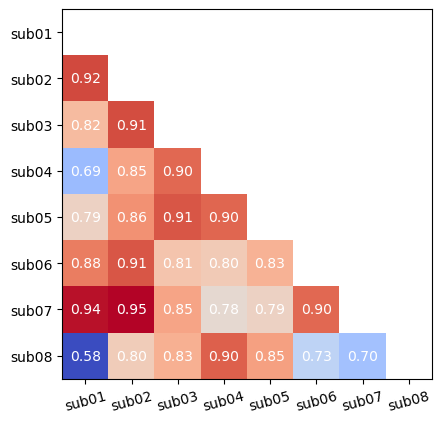

In [277]:
weights = nsd_weights
subjsimilarity = np.zeros((len(weights), len(weights)))
for isub in range(len(weights)):
    for jsub in range(len(weights)):
        subjsimilarity[isub,jsub] = np.corrcoef(weights[isub], weights[jsub])[0,1]
print( (subjsimilarity.sum() - len(weights))/(len(weights)**2 - len(weights)) )

fig, ax = plt.subplots()

eye = np.eye(len(weights))
upper_triangle_indices = np.triu_indices(eye.shape[0], 1)
eye[np.where(eye==1)] = np.nan
subjsimilarity[upper_triangle_indices] = np.nan
# 仅显示下三角部分的值
for i in range(subjsimilarity.shape[0]):
    for j in range(subjsimilarity.shape[1]):
        if i >= j:  # 仅下三角
            ax.text(j, i, f'{subjsimilarity[i, j]:.2f}', va='center', ha='center', color="white")
# cax = ax.matshow(subjsimilarity - eye, cmap="viridis")
ax.imshow(subjsimilarity - eye, cmap='coolwarm')
# 设置横轴ticklabel为sub01-sub09
ax.set_xticks(range(subjsimilarity.shape[1]))
ax.set_xticklabels([f'sub0{i+1}' if i < 9 else f'sub{i+1}' for i in range(subjsimilarity.shape[1])], rotation=15, ha='center')
ax.set_yticks(range(subjsimilarity.shape[0]))
ax.set_yticklabels([f'sub0{i+1}' if i < 9 else f'sub{i+1}' for i in range(subjsimilarity.shape[0])])
plt.show()

In [14]:
nod_small_model_path = pjoin(work_dir, 'build/lasso-feature-withinsub-concatevoxels/smaller-V1')
nod_small_models = sorted([pjoin(nod_small_model_path, _) for _ in os.listdir(nod_small_model_path) if 'linear' in _])
print(nod_small_models)
nod_small_weights = [joblib.load(nod_small_model).coef_ for nod_small_model in nod_small_models]

['/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/smaller-V1/sub-01_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/smaller-V1/sub-02_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/smaller-V1/sub-03_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/smaller-V1/sub-04_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concatevoxels/smaller-V1/sub-05_linear.pkl', '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/lasso-feature-withinsub-concat

In [26]:
formatted_list = map(lambda x: "{:.3f}".format(x), weights[0])
print(" ".join(formatted_list))
formatted_list = map(lambda x: "{:.3f}".format(x), weights[1])
print(" ".join(formatted_list))
np.corrcoef(weights[1], weights[0])

-0.016 -0.029 0.224 0.000 -0.072 0.017 0.005 -0.013 -0.016 0.061 -0.006 -0.070 0.002 0.045 0.049 0.028 0.012 0.023 0.018 -0.023 -0.035 -0.011 -0.036 -0.009 -0.014 -0.011 -0.002 0.001 0.018 -0.013 -0.038 0.003 -0.002 -0.006 -0.008 0.018 0.017 0.019 -0.014 -0.002 0.022 0.042 0.021 -0.001 0.005 0.083 -0.007 0.325 -0.005 0.051 -0.022 -0.053 0.010 0.002 0.018 -0.064 0.018 -0.014 -0.600 0.006 -0.015 0.010 0.002 0.000
0.003 -0.028 0.221 0.007 -0.074 0.002 0.002 -0.003 -0.000 0.126 -0.000 -0.071 -0.006 0.047 0.020 0.015 0.003 0.001 0.023 -0.025 -0.003 -0.027 -0.031 0.024 -0.007 -0.031 0.006 -0.003 0.002 -0.005 -0.016 -0.006 -0.037 0.004 -0.005 0.005 0.008 0.000 -0.020 -0.005 0.029 -0.011 0.019 0.014 -0.001 0.059 -0.001 0.133 -0.008 0.050 -0.013 -0.011 -0.005 -0.005 0.035 -0.061 0.012 -0.015 -0.369 0.001 -0.013 0.009 0.004 0.008


array([[1.        , 0.93766784],
       [0.93766784, 1.        ]])

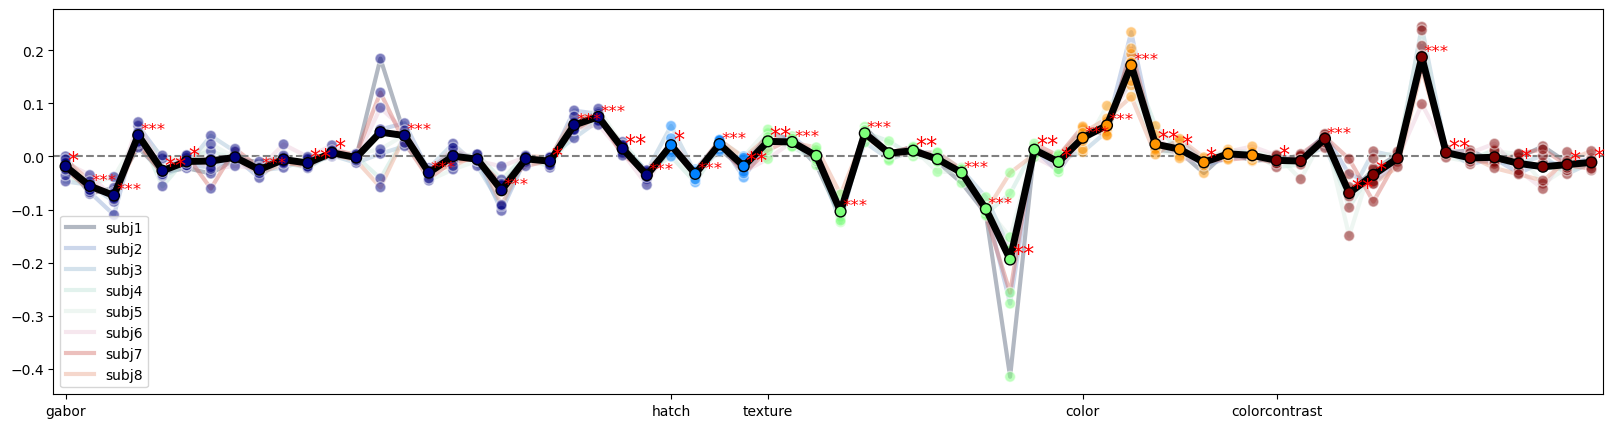

In [296]:
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
weights = nsd_weights

# 画个大图试试
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)

sub_betas = sub_betas[:, np.array(draw_sorting)]
mean_betas = sub_betas.mean(axis=0)
# plots
for isub in range(sub_betas.shape[0]):
    # if isub in [0,5,7]:
    ax.plot(sub_betas[isub], color=subcolors[isub], lw=3, alpha=0.4, label=f'subj{isub+1}')
    ax.scatter(np.arange(len(draw_sorting)), sub_betas[isub], color=draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend()
ax.plot(mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(draw_sorting)), mean_betas, color=draw_colors, s=60, edgecolors='black', zorder=5)
ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

from scipy import stats
_, p_value = stats.ttest_1samp(sub_betas, 0)
for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
for pos in np.where(p_value < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
plt.show()

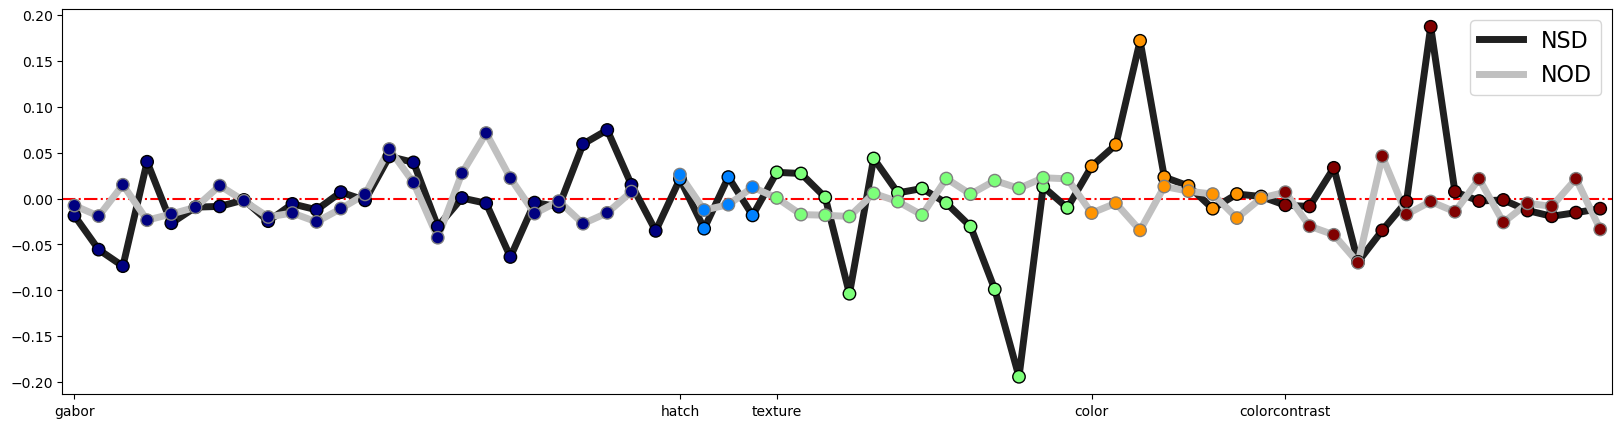

In [279]:
# nsd mean
nsdsub_betas = np.nan * np.zeros((len(nsd_weights), len(draw_sorting)))
nsdsub_betas[:, 0:len(nsd_weights[0])] = np.array(nsd_weights)
nsdsub_betas = nsdsub_betas[:, np.array(draw_sorting)]
nsdmean_betas = nsdsub_betas.mean(axis=0)

# nod mean
nodsub_betas = np.nan * np.zeros((len(nod_weights), len(draw_sorting)))
nodsub_betas[:, 0:len(nod_weights[0])] = np.array(nod_weights)
nodsub_betas = nodsub_betas[:, np.array(draw_sorting)]
nodmean_betas = nodsub_betas.mean(axis=0)

# # nod smaller mean
# nodsub_s_betas = np.nan * np.zeros((len(nod_small_weights), len(draw_sorting)))
# nodsub_s_betas[:, 0:len(nod_small_weights[0])] = np.array(nod_small_weights)
# nodsub_s_betas = nodsub_s_betas[:, np.array(draw_sorting)]
# nodmean_s_betas = nodsub_s_betas.mean(axis=0)

plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.plot((nsdmean_betas), color='#202020', lw=5,zorder=4, label='NSD')
ax.scatter(np.arange(len(draw_sorting)), (nsdmean_betas), color=draw_colors, s=80, edgecolors='black', zorder=5)

ax.plot((nodmean_betas), color='#c0c0c0', lw=5,zorder=4, label='NOD')
ax.scatter(np.arange(len(draw_sorting)), (nodmean_betas), color=draw_colors, s=80, edgecolors='gray', zorder=5)

# ax.plot(nodmean_s_betas, color='gray', lw=5,zorder=4, label='nod')
# ax.scatter(np.arange(len(draw_sorting)), nodmean_s_betas, color=draw_colors, s=60, ls='-.', edgecolors='gray', zorder=5)


ax.set_xlim([-0.5, 63.5])
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.axhline(y=0, color='red', ls='-.')
plt.legend(fontsize=16)
plt.show()

In [280]:
np.corrcoef(nsdmean_betas, np.nan_to_num(nodmean_betas))


array([[ 1.        , -0.08539233],
       [-0.08539233,  1.        ]])

In [248]:
import scipy.stats as stats
def calculate_spearman_correlation(X, Y):
    return stats.spearmanr(X, Y)[0]
calculate_spearman_correlation(nsdmean_betas, np.nan_to_num(nodmean_betas))

-0.17541208791208787

### 比较视觉层级不同 ROI 的特征选择

In [97]:
# 加载不同 ROI 模型
nod_model_path = pjoin(work_dir, 'build/roi-concatemodel')

nodroi_models = {}
rois = ['V1', 'V2', 'V3', 'V4']
layer = 'conv2'
for roi in rois:
    nodroi_models[roi] = sorted([pjoin(nod_model_path, roi, _) for _ in os.listdir(pjoin(nod_model_path, roi)) if layer in _])

# 加载模型参数
nodroi_weights = {}
for roi in rois:
    nodroi_weights[roi] = [joblib.load(roi_model).coef_ for roi_model in nodroi_models[roi]]
print(len(nodroi_weights['V1']))
print(len(nodroi_weights['V2']))
print(len(nodroi_weights['V3']))
print(len(nodroi_weights['V4']))

9
9
9
9


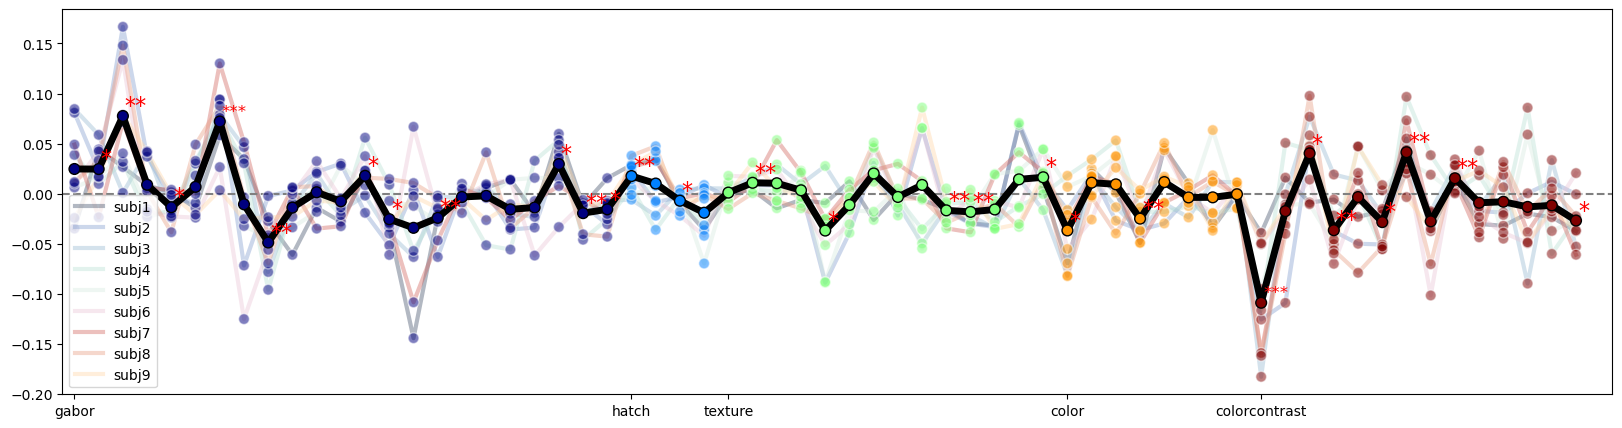

In [7]:
# 看看单ROI的情况
# 信息量太大，简单summary成 sub x feature，按 set 聚类
subcolors = ['#404e67',  '#809bce',  '#95b8d1',  '#b8e0d4',  '#d6eadf',  '#eac4d5',  '#d1625c',  '#e89c81', '#ffd6a5']
weights = nodroi_weights['V1']

# 画个大图试试
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
sub_betas = np.nan * np.zeros((len(weights), len(draw_sorting)))
sub_betas[:, 0:len(weights[0])] = np.array(weights)

sub_betas = sub_betas[:, np.array(draw_sorting)]
mean_betas = sub_betas.mean(axis=0)
# plots
for isub in range(sub_betas.shape[0]):
    # if isub in [0,5,7]:
    ax.plot(sub_betas[isub], color=subcolors[isub], lw=3, alpha=0.4, label=f'subj{isub+1}')
    ax.scatter(np.arange(len(draw_sorting)), sub_betas[isub], color=draw_colors, s=60, alpha=0.5, edgecolors='white', zorder=4)
ax.legend()
ax.plot(mean_betas, color='black', lw=5,zorder=4)
ax.scatter(np.arange(len(draw_sorting)), mean_betas, color=draw_colors, s=60, edgecolors='black', zorder=5)
ax.set_xlim([-0.5, 63.5])
# ax.set_ylim([-0.62, 0.38])
# ax.set_ylim([-0.1, 0.1])
ax.axhline(y=0, color='gray', ls='--')

from scipy import stats
_, p_value = stats.ttest_1samp(sub_betas, 0)
for pos in np.where(np.logical_and(p_value < 0.05, p_value >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(p_value < 0.01, p_value >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
for pos in np.where(p_value < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+0.08, mean_betas[pos]+0.01, infotxt, fontsize=12, color='red',
    horizontalalignment='left', verticalalignment='center',zorder=7)
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
plt.show()

V1 [-0.00210494 -0.02542024 -0.0366682   0.00113263  0.01785069 -0.00800523
 -0.0131363  -0.01573767 -0.02680546 -0.00903135  0.01543759 -0.01811888
 -0.01739486 -0.00754576  0.01763547 -0.00322155 -0.00361708 -0.00369799
 -0.01938858 -0.0137395  -0.02756343  0.04033438 -0.01384738  0.00893653
 -0.02409717  0.02463577 -0.00052097 -0.00324894 -0.03676784 -0.01558114
 -0.01897594  0.00877023 -0.01560332 -0.00700434 -0.01345922 -0.02487439
  0.01160978  0.01643597  0.00684723 -0.03405337 -0.01123313  0.01016483
 -0.03643252  0.00148314 -0.0105581  -0.10884879  0.00937616  0.07210065
  0.01106403 -0.01660317 -0.02836027  0.02022692  0.00343201 -0.00330817
  0.02469715  0.01047323 -0.01160376  0.04147325  0.01092217  0.01434148
 -0.04868893  0.02961859  0.07757335]
V2 [-0.00797243 -0.02958241 -0.04064575 -0.00502795  0.01074816 -0.02370391
 -0.02186073 -0.01924008 -0.03396122 -0.0250824   0.01792208 -0.01674172
 -0.02221029  0.00033379  0.03134715  0.00447707 -0.0139062   0.00261641
 -0.011

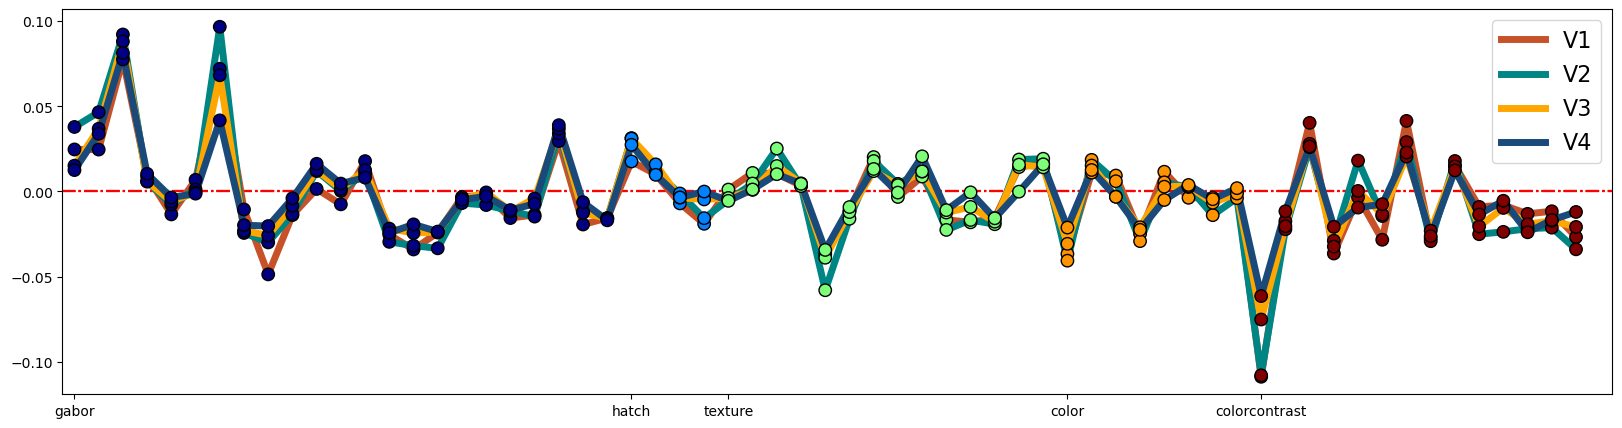

In [99]:
# roi mean
roimean = {}
for iroi, roi in enumerate(['V1', 'V2', 'V3', 'V4']):
    nodsub_betas = np.nan * np.zeros((len(nodroi_weights[roi]), len(draw_sorting)))
    nodsub_betas[:, 0:len(nodroi_weights[roi][0])] = np.array(nodroi_weights[roi])
    print(roi, nodsub_betas.mean(axis=0))
    np.save(f'/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/build/roi-concatemodel/{roi}-params.npy', nodsub_betas.mean(axis=0))
    nodsub_betas = nodsub_betas[:, np.array(draw_sorting)]
    roimean[iroi] = nodsub_betas.mean(axis=0)
    

plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))

colors = ['#c7522a', '#008585', '#ffa600', '#194a7a'] 
for iroi, roi in enumerate(['V1', 'V2', 'V3', 'V4']):
    ax.plot(roimean[iroi], color=colors[iroi], lw=5,zorder=4, label=roi)
    ax.scatter(np.arange(len(draw_sorting)), roimean[iroi], color=draw_colors, s=80, edgecolors='black', zorder=5)

    ax.set_xlim([-0.5, 63.5])
    ax.set_xticks(draw_ticks[0:-1])
    ax.set_xticklabels(draw_tickslabels)
    ax.axhline(y=0, color='red', ls='-.')
    # ax.set_ylim([-0.105, 0.105])
plt.legend(fontsize=16)
plt.show()

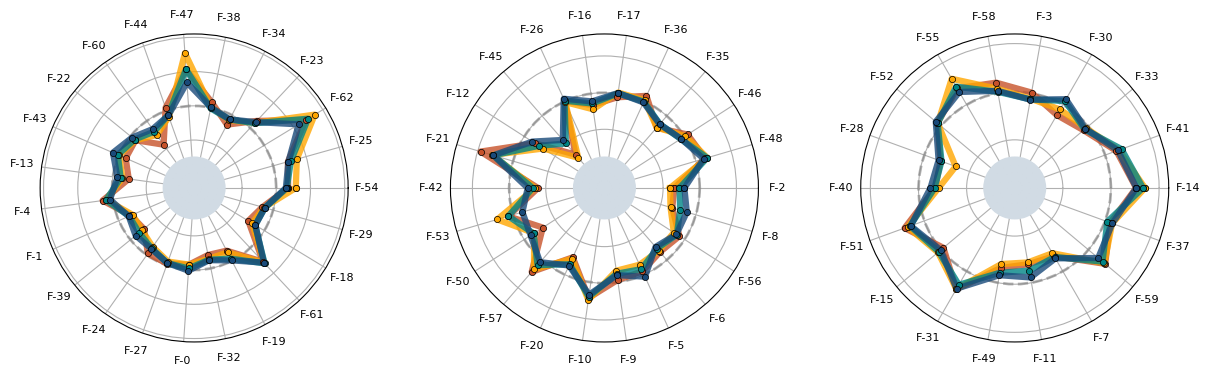

In [363]:
# 雷达图 - family-wise

fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw=dict(polar=True))

# 获取"rainbow"颜色映射
cmap = plt.get_cmap('coolwarm')

roi_names = ['V1', 'V2', 'V3', 'V4']
# 选择四个颜色
colors = ['#c7522a', '#ffa600', '#008585', '#194a7a'] 

families = [gabor_channel, color_channel, texture_channel]
for ifamily, ax in enumerate(axs):
    family_channel = families[ifamily]
    # if ifamily == 0:
    #     gabor_channel.pop(gabor_channel.index(63))
    # 画gabor channel的雷达图
    labels = np.array([f"F-{i}" for i in family_channel])  # 25个辐轴标签，使用英文

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()  # 分布在圆周上的角度
    angles += angles[:1]  # 闭合图形

    for iroi, roi_name in enumerate(roi_names):
        mean_beta = np.nan * np.zeros((len(family_channel),))
        mean_beta = np.array(nodroi_weights[roi_name]).mean(axis=0)[np.array(family_channel)]
        mean_beta =  np.concatenate((mean_beta,[mean_beta[0]]))

        ax.plot(angles, mean_beta, lw=4.5,zorder=4, color=colors[iroi],label=f'V{iroi+1}', alpha=0.8)
        ax.scatter(angles, mean_beta, color=colors[iroi],s=20, edgecolors='black', zorder=5,lw=0.5)#
    
    # ref line
    lineangles = np.linspace(0, 2*np.pi, 50, endpoint=False).tolist()
    lineangles += lineangles[:1]
    ax.plot(lineangles, [0]*len(lineangles), lw=2,zorder=3, color='gray', alpha=0.6, ls='--')

    # 画 中心 legend
    inset_ax = inset_axes(ax, width="22%", height="22%", loc='center', borderpad=-2)
    inset_ax.set_aspect('equal')  # 设置等比例，确保圆形显示为圆形
    for i, ecc in enumerate(eccentricities):
        inner_radius = 0 if i == 0 else eccentricities[i-1]
        outer_radius = ecc
        wedge = Wedge((0, 0), outer_radius, 0, 360, width=outer_radius-inner_radius, color='#d1dbe4')
        inset_ax.add_patch(wedge)
    inset_ax.set_xlim(-1.1, 1.1)
    inset_ax.set_ylim(-1.1, 1.1)
    inset_ax.axis('off')
    
    # # 添加显著性
    # if ifamily== 0:
    #     hieghtloc = 0.07
    # if ifamily==1:
    #     hieghtloc = 0.07
    # if ifamily==2:
    #     hieghtloc = 0.06
    # draw_pvalues = pvalues[np.array(family_channel)]
    # for pos in np.where(np.logical_and(draw_pvalues < 0.05, draw_pvalues >= 0.01)==1)[0]:
    #     infotxt = '*'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center', zorder=7)
    # for pos in np.where(np.logical_and(draw_pvalues < 0.01, draw_pvalues >= 0.001)==1)[0]:
    #     infotxt = '**'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center',zorder=7)
    # for pos in np.where(draw_pvalues < 0.001)[0]:
    #     infotxt = '***'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center',zorder=7)


    # 设置辐轴的标签，使用英文
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)
    if ifamily== 0:
        ax.set_ylim([-0.12, 0.105])
        ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
    if ifamily==1:
        ax.set_ylim([-0.13, 0.08])
        ax.set_yticks([-0.1, -0.05, 0, 0.05])
    if ifamily==2:
        ax.set_ylim([-0.1, 0.06]) 
        ax.set_yticks([-0.1, -0.05, 0, 0.05])
    # ax.set_yticks([0,0.05,0.1])
    ax.set_yticklabels([])

plt.show()

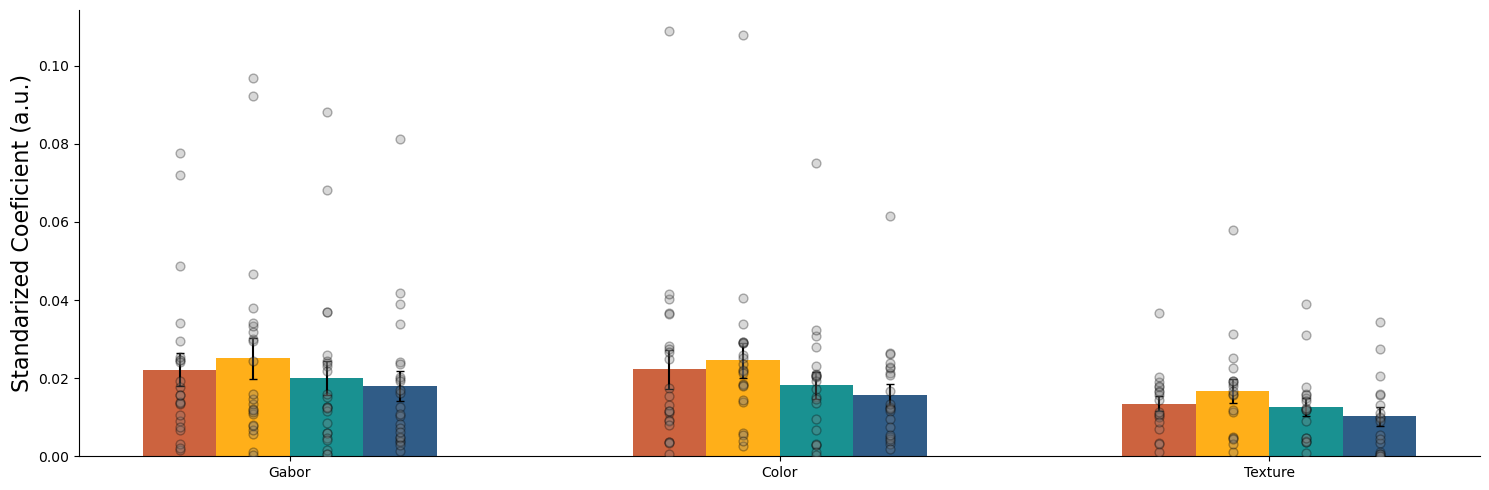

In [10]:
gabor_v1 = np.array(nodroi_weights['V1']).mean(axis=0)[np.array(gabor_channel)]
gabor_v2 = np.array(nodroi_weights['V2']).mean(axis=0)[np.array(gabor_channel)]
gabor_v3 = np.array(nodroi_weights['V3']).mean(axis=0)[np.array(gabor_channel)]
gabor_v4 = np.array(nodroi_weights['V4']).mean(axis=0)[np.array(gabor_channel)]
# gabor_weights = {0:gabor_v1, 1:gabor_v2, 2:gabor_v3, 3:gabor_v4}
gabor_weights = {0:np.abs(gabor_v1), 1:np.abs(gabor_v2), 2:np.abs(gabor_v3), 3:np.abs(gabor_v4)}

color_v1 = np.array(nodroi_weights['V1']).mean(axis=0)[np.array(color_channel)]
color_v2 = np.array(nodroi_weights['V2']).mean(axis=0)[np.array(color_channel)]
color_v3 = np.array(nodroi_weights['V3']).mean(axis=0)[np.array(color_channel)]
color_v4 = np.array(nodroi_weights['V4']).mean(axis=0)[np.array(color_channel)]
# color_weights = {0:color_v1, 1:color_v2, 2:color_v3, 3:color_v4}
color_weights = {0:np.abs(color_v1), 1:np.abs(color_v2), 2:np.abs(color_v3), 3:np.abs(color_v4)}

texture_v1 = np.array(nodroi_weights['V1']).mean(axis=0)[np.array(texture_channel)]
texture_v2 = np.array(nodroi_weights['V2']).mean(axis=0)[np.array(texture_channel)]
texture_v3 = np.array(nodroi_weights['V3']).mean(axis=0)[np.array(texture_channel)]
texture_v4 = np.array(nodroi_weights['V4']).mean(axis=0)[np.array(texture_channel)]
# texture_weights = {0:texture_v1, 1:texture_v2, 2:texture_v3, 3:texture_v4}
texture_weights = {0:np.abs(texture_v1), 1:np.abs(texture_v2), 2:np.abs(texture_v3), 3:np.abs(texture_v4)}


plt.style.use('default')
# 准备绘图数据
model_rois = ['V1', 'V2', 'V3', 'V4']
model_colors =  ['#c7522a', '#ffa600', '#008585', '#194a7a'] 
n_groups = len(model_rois)
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

fig, ax = plt.subplots(figsize=(15,5))
family_indices = np.arange(3)  # 数据集数量，这里有两个：测试集和验证集
bar_width = 0.15

# 对于测试集和验证集分别绘制四个模型的性能
for i, roi in enumerate(model_rois):
    # 计算每个模型的平均性能和标准误
    means = [np.mean(gabor_weights[i]), np.mean(color_weights[i]), np.mean(texture_weights[i]),]
    sems = [np.std(gabor_weights[i], ddof=1) / np.sqrt(len(gabor_weights[i])), 
            np.std(color_weights[i], ddof=1) / np.sqrt(len(color_weights[i])),
            np.std(texture_weights[i], ddof=1) / np.sqrt(len(texture_weights[i])),]
    
    # 绘制柱状图
    rects = ax.bar(family_indices + i*bar_width, means, bar_width, yerr=sems, label=model_rois[i],
                   capsize=3, color=model_colors[i], alpha=0.9)
    
    # 在柱状图上添加原始性能数据点
    for idx, familiesweights in enumerate([gabor_weights[i], color_weights[i], texture_weights[i]]):
        ax.scatter(np.ones_like(familiesweights) * (family_indices[idx] + i*bar_width), familiesweights, color='grey', s=40, 
                   edgecolor='black', linewidth=1., alpha=0.3, zorder=3)

# 添加图表细节
# ax.set_xlabel('Dataset')
ax.set_ylabel('Standarized Coeficient (a.u.)', fontsize=16)
# ax.set_title('Performance by Dataset and ROI')
ax.set_xticks(family_indices + bar_width*1.5)

ax.set_xticklabels(['Gabor', 'Color', 'Texture'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.legend(title='ROI', bbox_to_anchor=(0.85, 1), loc='upper left')

plt.tight_layout()
plt.show()
    

In [492]:
from scipy.stats import ttest_rel
data1 = texture_weights[0]
data2 = texture_weights[1]
t_statistic, p_value = ttest_rel(data1, data2)
print(f"T统计量: {t_statistic}, P值: {p_value}")

T统计量: -1.5763540964124052, P值: 0.1333698432238471


### 将系数投射到stim pc空间

In [399]:
import joblib
axis_path = pjoin(work_dir, 'prep/stimaxis')
shared_space_path = pjoin(work_dir, 'prep/shared-pcspace')
nod_axis = np.squeeze(np.load(pjoin(axis_path, 'googlenet_conv2_pca_space.npy')))[:,0:10]
nsd_axis = np.squeeze(np.load(pjoin(axis_path, 'NSD_googlenet_conv2_pca_space.npy')))[:,0:10]
nsd64_axis = np.load(pjoin(axis_path, 'NSD_googlenet_conv2-64_pca_space.npy'))[:,0:10]
nod_space = np.load(pjoin(shared_space_path, 'axisfromNOD.npy'))
nsd_space= np.load(pjoin(shared_space_path, 'axisfromNSD.npy'))
affine_o2s = joblib.load(pjoin(shared_space_path, 'nod2nsd_affine.joblib'))
affine_s2o = joblib.load(pjoin(shared_space_path, 'nsd2nod_affine.joblib'))

In [396]:
v1_weights = np.array(nodroi_weights['V1']).mean(axis=0)
v2_weights = np.array(nodroi_weights['V2']).mean(axis=0)
v3_weights = np.array(nodroi_weights['V3']).mean(axis=0)
v4_weights = np.array(nodroi_weights['V4']).mean(axis=0)
v1_weights.shape

(63,)

In [409]:
v1_vector = np.dot(v1_weights[np.newaxis, :], nod_axis)[0]
v2_vector = np.dot(v2_weights[np.newaxis, :], nod_axis)[0]
v3_vector = np.dot(v3_weights[np.newaxis, :], nod_axis)[0]
v4_vector = np.dot(v4_weights[np.newaxis, :], nod_axis)[0]

In [427]:
v4_vector, v3_vector, v2_vector, v1_vector

(array([-8.42637326e-03,  4.55042583e-03, -5.12615070e-04,  1.13318855e-03,
        -5.69615467e-04,  3.49855729e-03,  1.31962612e-02,  1.81497607e-03,
        -9.58249747e-05,  7.28863834e-05]),
 array([-1.00693756e-02,  4.30661915e-03, -3.64696832e-04,  1.74089968e-03,
        -1.33400401e-03,  2.31638880e-03,  1.05994499e-02,  7.60084004e-04,
         8.82530008e-05,  8.35499350e-04]),
 array([-1.44833492e-02,  6.49695937e-03,  1.57632636e-03, -5.10135212e-04,
        -1.77929195e-03, -7.61569979e-05,  1.45523601e-02,  5.58906137e-04,
         2.09976528e-04,  3.39852785e-03]),
 array([-0.01784533,  0.0034813 ,  0.00282435,  0.00227978, -0.00097975,
         0.00056139,  0.00913126,  0.00425504, -0.00759781,  0.00464215]))

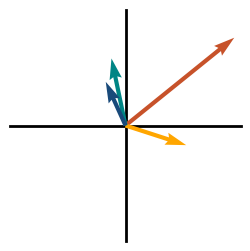

In [487]:
# 定义向量的起点和终点
from matplotlib.ticker import NullLocator, NullFormatter
start_point = [0, 0]  # 向量的起点   # 向量的终点

# 创建一个图形和坐标轴
fig, ax = plt.subplots(figsize=(3,3))

# 使用箭头来表示向量
# '->'指定了箭头的样式
# 'color'指定了箭头的颜色
# 'lw'指定了线的宽度
model_vectors = [v1_vector, v2_vector, v3_vector, v4_vector]
model_rois = ['V1', 'V2', 'V3', 'V4']
model_colors =  ['#c7522a', '#ffa600', '#008585', '#194a7a']
axisid = 2 
for i, roi in enumerate(model_rois):
    ax.quiver(start_point[0], start_point[1], model_vectors[i][axisid], model_vectors[i][axisid+1], angles='xy', scale_units='xy',\
        width=0.018, scale=0.6, color=model_colors[i], lw=10,zorder=5)

# 设置坐标轴的范围
lim = [-0.005, 0.005] #2345
ax.set_xlim(lim)
ax.set_ylim(lim)
# plt.axis('equal')
# plt.axis('off')
ax.set_xticks(np.linspace(*lim,5))
ax.set_yticks(np.linspace(*lim,5))
ax.set_xticklabels([])
ax.set_yticklabels([])
# 绘制网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# # 设置刻度的位置
# 设置图形的横纵轴比例相等，使其成为正方形
ax.set_aspect('equal', 'box')

# 移动坐标轴到中心
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# 隐藏右边和上面的边框
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
# 设置坐标轴宽度
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
# 移除刻度值
ax.xaxis.set_major_locator(NullLocator())
ax.yaxis.set_major_locator(NullLocator())

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.show()

In [436]:
np.linspace(*[-0.005, 0.005],5)

array([-0.005 , -0.0025,  0.    ,  0.0025,  0.005 ])

<StemContainer object of 3 artists>

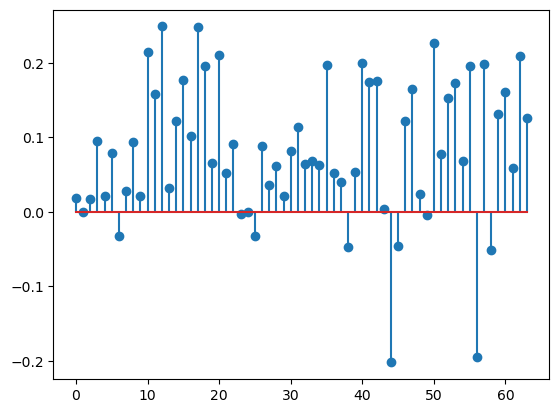

In [48]:
nod_space_draw = np.zeros(64)
nod_space_draw[0:63] = nod_space[:,0]
plt.stem(nod_space_draw[np.array(draw_sorting)])

In [282]:
nod_space.shape, nsd_space.shape

((63, 14), (63, 14))

In [232]:
' '.join( ['{:.3f}'.format(nod_space[_,1].astype(np.float16)) for _ in range(63)]), ' '.join( ['{:.3f}'.format(nsd_space[_,1].astype(np.float16)) for _ in range(63)])

('-0.144 -0.014 0.097 0.005 -0.294 0.185 -0.145 -0.160 0.174 -0.103 -0.038 -0.149 0.020 -0.167 -0.130 -0.010 -0.092 0.044 0.224 -0.109 0.126 -0.026 0.159 0.022 0.039 -0.148 0.005 0.015 -0.147 -0.008 -0.191 -0.174 0.183 -0.008 0.002 0.003 0.032 -0.067 0.008 0.134 -0.072 0.254 0.106 0.069 -0.021 -0.084 -0.177 -0.026 -0.085 -0.039 0.084 0.299 0.072 0.117 -0.150 0.055 -0.201 0.120 -0.025 0.156 -0.181 0.144 0.024',
 '-0.083 -0.078 0.004 -0.146 -0.267 0.228 -0.026 -0.064 0.201 -0.169 -0.037 -0.112 0.041 -0.215 -0.220 -0.101 -0.160 0.099 0.182 -0.122 0.193 -0.086 0.178 0.000 0.076 -0.103 -0.094 0.020 -0.111 0.025 -0.096 -0.105 0.139 0.046 0.042 -0.015 0.063 0.003 0.021 0.154 0.004 0.244 0.104 0.116 0.009 -0.166 -0.073 -0.113 -0.071 -0.121 0.130 0.223 0.106 0.013 -0.164 0.031 -0.237 0.071 -0.161 0.057 -0.151 0.098 0.024')

In [283]:
dim14_nsd_w = np.dot(np.array(nsd_weights).mean(axis=0)[0:63], nsd_space)
dim14_nod_w = np.dot(np.array(nod_weights).mean(axis=0), nod_space)


In [284]:
affine_o2s.predict(dim14_nod_w[np.newaxis, :]), dim14_nsd_w

(array([[-0.01054926,  0.00055807,  0.00361554, -0.00629492,  0.00298047,
          0.00660455, -0.01006633, -0.01377741, -0.00829717,  0.01937193,
         -0.01607473,  0.01085647,  0.01487167,  0.02820198]]),
 array([ 0.05190672,  0.02446306,  0.07562186, -0.02806423,  0.01714194,
         0.0375365 , -0.05107501, -0.03950436, -0.00876875,  0.02553921,
         0.05867042, -0.0403041 , -0.00107184, -0.11019763]))

In [285]:
affine_s2o.predict(dim14_nsd_w[np.newaxis, :]), dim14_nod_w

(array([[-0.02271742,  0.04445368,  0.05946872,  0.01220078, -0.01646737,
          0.02916341, -0.04832463, -0.07207718,  0.00324652, -0.02386855,
         -0.02638395, -0.00568861,  0.00928903, -0.07968223]]),
 array([-0.01784533,  0.0034813 ,  0.00282435,  0.00227978, -0.00097975,
         0.00913126,  0.00425504, -0.00759781, -0.00211228, -0.02492872,
         0.05782736, -0.00236843, -0.02220051,  0.101695  ]))

In [290]:
np.corrcoef(dim14_nod_w[0:6], affine_s2o.predict(dim14_nsd_w[np.newaxis, :])[0,0:6])

array([[1.        , 0.69452462],
       [0.69452462, 1.        ]])

In [287]:
np.corrcoef(dim14_nsd_w[0:6], affine_o2s.predict(dim14_nod_w[np.newaxis, :])[0,0:6])

array([[1.        , 0.26609239],
       [0.26609239, 1.        ]])

### 在 retino grid 上考察 V1 特征加工的特性

In [61]:
# 先看看模型表现
layer = 'conv2'
roi = 'V1'
gridpath = pjoin(work_dir, 'build/roi-concatemodel/retino-grid')
gridshufflepath = pjoin(work_dir, f'build/roi-concatemodel/shuffleperformance/')
gridmodelpath = pjoin(work_dir, f'build/roi-concatemodel/retino-grid/{roi}')

grid_shuffle_cor = np.load(pjoin(gridshufflepath, f'all-sub_model-googlenet-{layer}_V1-grid-shuffle-cor.npy'))
grid_test_cor = np.load(pjoin(gridpath, roi, f'all-sub_layer-googlenet-{layer}_grid-test-cor.npy'))

grid_shuffle_cor.shape, grid_test_cor.shape
thres_grid_shufflecor = np.percentile(grid_shuffle_cor, 99.9, axis=-1) 

In [77]:
summary_grid_models = {}
for i in range(5):
    for j in range(4):
        summary_grid_models[f'E{i}A{j}'] = []

for isub, sub in enumerate([f'sub-0{_+1}' for _ in range(9)]):

    grid_models = np.load(pjoin(gridmodelpath,  f'sub-0{isub+1}_layer-googlenet-{layer}_grid-models.npy'), allow_pickle=True).item()

    poses = np.where(grid_test_cor[isub] > thres_grid_shufflecor[isub])
    for ipos, jpos in zip(poses[0], poses[1]):
        summary_grid_models[f'E{ipos}A{jpos}'].append(grid_models[f'E{ipos}A{jpos}'])
    # plt.imshow(draw_cor)
    # plt.colorbar()
    # plt.show()

for i in range(5):
    for j in range(4):
        print(f'E{i}A{j}:', len(summary_grid_models[f'E{i}A{j}']), end=' ')
np.save(pjoin(gridmodelpath.replace('V1', ''), f'grid-summary_{layer}_{roi}.npy'), summary_grid_models)

E0A0: 9 E0A1: 8 E0A2: 9 E0A3: 9 E1A0: 9 E1A1: 9 E1A2: 9 E1A3: 9 E2A0: 9 E2A1: 9 E2A2: 9 E2A3: 9 E3A0: 9 E3A1: 9 E3A2: 8 E3A3: 8 E4A0: 6 E4A1: 5 E4A2: 5 E4A3: 6 

In [83]:
Emodels = {}
for i in range(5):
    Emodels[f'E{i}'] = []
for key, models in summary_grid_models.items():
    for i in range(5):
        if f'E{i}' in key:
            Emodels[f'E{i}'].extend(models)
for i in range(5):
    print(f'E{i}', len(Emodels[f'E{i}']), end=', ')
np.save(pjoin(gridmodelpath.replace('V1', ''), f'ecc-summary_{layer}_{roi}.npy'), Emodels)

Amodels = {}
for i in range(4):
    Amodels[f'A{i}'] = []
for key, models in summary_grid_models.items():
    for i in range(4):
        if f'A{i}' in key:
            Amodels[f'A{i}'].extend(models)
for i in range(4):
    print(f'A{i}', len(Amodels[f'A{i}']), end=', ')
np.save(pjoin(gridmodelpath.replace('V1', ''), f'ang-summary_{layer}_{roi}.npy'), Amodels)

E0 35, E1 36, E2 36, E3 34, E4 22, A0 42, A1 40, A2 40, A3 41, 

In [89]:
np.array([_.coef_ for _ in Emodels['E0']])

(35, 63)

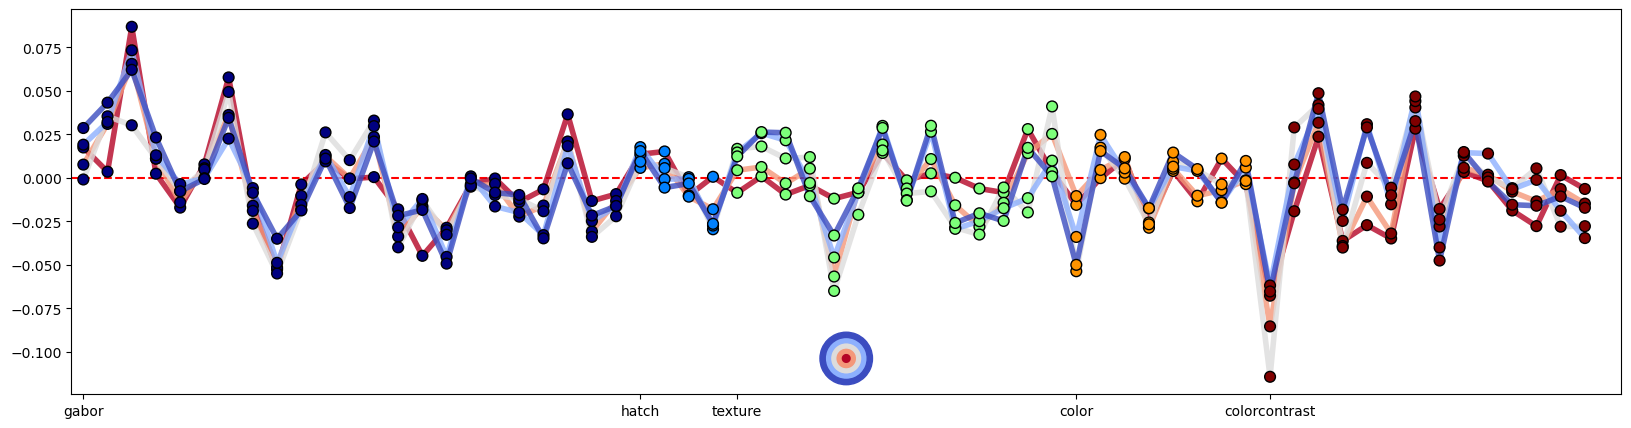

In [118]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge
import matplotlib.cm as cm
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
# 获取"rainbow"颜色映射
cmap = plt.get_cmap('coolwarm')

quater_names = [f'E{_}' for _ in range(5)]
# 选择四个颜色
colors = [cmap(i) for i in np.linspace(0, 1, 5)][::-1]

for iquater, quater_name in enumerate(quater_names):
    mean_beta = np.nan * np.zeros((len(draw_sorting)))
    mean_beta = np.array([_.coef_ for _ in Emodels[quater_name]]).mean(axis=0)
    mean_beta = mean_beta[np.array(draw_sorting)]
    ax.plot(mean_beta, lw=4, zorder=4, color=colors[iquater], label=f'ecc-{iquater+1}', alpha=0.8)
    ax.scatter(np.arange(len(draw_sorting)), mean_beta, color=draw_colors,s=60, edgecolors='black', zorder=5)

eccentricities = [0.2, 0.4, 0.6, 0.8, 1]
ax_inset = inset_axes(ax, width="15%", height="15%", loc='lower center')
# 画出每个圆环
for i, ecc in enumerate(eccentricities):
    inner_radius = 0 if i == 0 else eccentricities[i-1]
    outer_radius = ecc
    wedge = Wedge((0, 0), outer_radius, 0, 360, width=outer_radius-inner_radius, color=colors[i])
    ax_inset.add_patch(wedge)
ax_inset.set_xlim(-1.1, 1.1)
ax_inset.set_ylim(-1.1, 1.1)
# 设置插入圆盘的轴为等比例，隐藏坐标轴
ax_inset.set_aspect('equal')

ax_inset.axis('off')

ax.set_xlim([-0.5, 63.5])
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.axhline(y=0, color='red', ls='--')

# draw_pvalues = pvalues[np.array(draw_sorting)]
# posoffset =0
# for pos in np.where(np.logical_and(draw_pvalues < 0.05, draw_pvalues >= 0.01)==1)[0]:
#     infotxt = '*'
#     ax.text(pos+posoffset, mean_beta[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='center', verticalalignment='center', zorder=7)
# for pos in np.where(np.logical_and(draw_pvalues < 0.01, draw_pvalues >= 0.001)==1)[0]:
#     infotxt = '**'
#     ax.text(pos+posoffset, mean_beta[pos]+0.01, infotxt, fontsize=16, color='red',
#     horizontalalignment='center', verticalalignment='center',zorder=7)
# for pos in np.where(draw_pvalues < 0.001)[0]:
#     infotxt = '***'
#     ax.text(pos+posoffset, mean_beta[pos]+0.01, infotxt, fontsize=12, color='red',
#     horizontalalignment='center', verticalalignment='center',zorder=7)
# for _ in np.arange(64):
#     ax.text(_, 0, draw_sorting[_], fontsize=12, color='green',
#         horizontalalignment='center', verticalalignment='center',zorder=7)
# plt.legend()
plt.show()

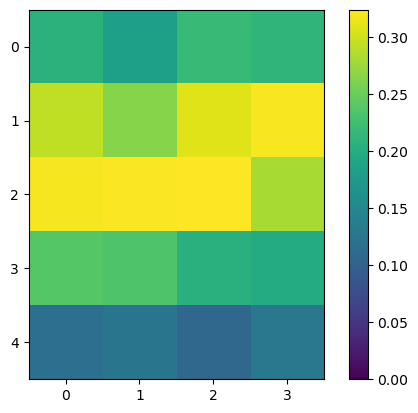

In [57]:
draw_grid = np.nanmean(grid_test_cor,axis=0)
plt.imshow(draw_grid, vmin=0)
plt.colorbar()

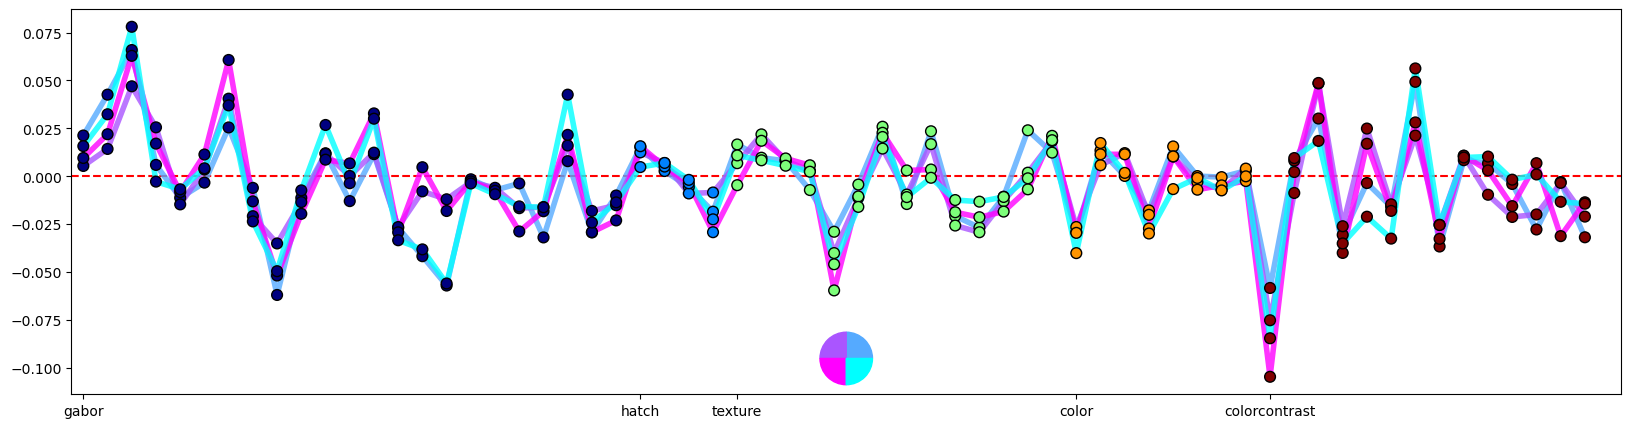

In [119]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge
import matplotlib.cm as cm
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
# 获取"rainbow"颜色映射
cmap = plt.get_cmap('cool')
quater_names = [f'A{_}' for _ in range(4)]

ax_inset = inset_axes(ax, width="15%", height="15%", loc='lower center')

# 选择八个颜色
colors = [cmap(i) for i in np.linspace(0, 1, 4)]
colors = [colors[_] for _ in [1,2,3,0]]
for iquater, quater_name in enumerate(quater_names):
    mean_beta = np.nan * np.zeros((len(draw_sorting)))
    mean_beta = np.array([_.coef_ for _ in Amodels[quater_name]]).mean(axis=0)
    mean_beta = mean_beta[np.array(draw_sorting)]
    ax.plot(mean_beta, lw=4, zorder=4, color=colors[iquater], label=f'ecc-{iquater+1}', alpha=0.8)
    ax.scatter(np.arange(len(draw_sorting)), mean_beta, color=draw_colors,s=60, edgecolors='black', zorder=5)

for i in range(4):
    theta1, theta2 = i * 90, (i + 1) * 90
    wedge = Wedge((0, 0), 1, theta1, theta2, color=colors[i])
    ax_inset.add_patch(wedge)

# 设置插入圆盘的轴为等比例，隐藏坐标轴
ax_inset.set_aspect('equal')
ax_inset.set_xlim(-1.1, 1.1)
ax_inset.set_ylim(-1.1, 1.1)
ax_inset.axis('off')

ax.set_xlim([-0.5, 63.5])
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.axhline(y=0, color='red', ls='--')
# plt.legend()
plt.show()

### 对比不同 eccentricity 上 被试平均的系数

In [337]:
# 加载不同 ecc bin 被试的模型
ecc_models = {}
quater_names = [f'ecc-quater{_+1}' for _ in range(4)]

dataset_path = {'nod' : 'build/lasso-feature-withinsub-concatevoxels/draft-quaters',
                'nsd' : 'NSD-mfm/build/lasso-feature-withinsub-concatevoxels/',      
    }
dataset = 'nod'

for quater_name in quater_names:

    quater_model_path = pjoin(work_dir, f'{dataset_path[dataset]}/{quater_name}')
    ecc_models[quater_name] = sorted([pjoin(quater_model_path, _) for _ in os.listdir(quater_model_path) if 'V1-linear' in _])
    ecc_models[quater_name+'-w'] = np.array([joblib.load(model).coef_ for model in ecc_models[quater_name]])

    print(quater_name+'-w' , ecc_models[quater_name+'-w'].shape)

ecc-quater1-w (9, 63)
ecc-quater2-w (9, 63)
ecc-quater3-w (9, 63)
ecc-quater4-w (9, 63)


['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'] ['ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4']


In [126]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
subject = np.tile([f'S{_+1}' for _ in range(9)], 4).tolist()
level = np.repeat([f'ecc{_+1}' for _ in range(4)], 9).tolist()
print(subject, level)

pvalues = np.nan*np.zeros(64)
for feature_id in draw_sorting:
    if feature_id == 63:
        continue
    # print(f'feature{feature_id}==================')
    values = []
    for quater_name in quater_names:
        values.extend(ecc_models[quater_name+'-w'][:,feature_id].tolist())
    # 假设这是你的实验数据，其中subject表示被试，level表示不同水平，value表示测量值
    data = {
    'subject': subject,
    'ecc': level,
    'value': values
    }

    # 转换为DataFrame
    df = pd.DataFrame(data)

    # 进行重复测量ANOVA
    anova = AnovaRM(data=df, depvar='value', subject='subject', within=['ecc'])
    result = anova.fit()
    pvalues[feature_id] = result.anova_table['Pr > F']['ecc']
    # 打印结果
    print(f'significance of feature{feature_id}', result.anova_table['Pr > F']['ecc'])

['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9'] ['ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc1', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc2', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc3', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4', 'ecc4']
significance of feature0 0.8766285444206269
significance of feature1 0.010038294319549756
significance of feature4 0.48383775585983235
significance of feature13 0.07997211480973951
significance of feature19 0.08157507809174269
significance of feature22 0.04382383584808311
significance of feature23 0.0443021491903948
significance of feature27 0.47248538567356513
significance of feature32 0.41516398349990846
significance of feature34 0.7683386049616501
significance of feature39 0.10044043218

In [129]:
np.where(pvalues<0.05)
fdr_q = 0.05
ref_line = fdr_q * np.linspace(0, 1, len(pvalues))
sorted_p = np.sort(pvalues)
p_thres = sorted_p[np.where(sorted_p <= ref_line)[0][-1]]
np.sum(pvalues < p_thres)

3

In [212]:
np.where(pvalues<0.05)

(array([ 1,  3,  8, 10, 16, 18, 21, 22, 23, 25, 28, 37, 48, 49, 55, 58]),)

In [67]:
ecc_models.keys()

dict_keys(['ecc-quater1', 'ecc-quater1-w', 'ecc-quater2', 'ecc-quater2-w', 'ecc-quater3', 'ecc-quater3-w', 'ecc-quater4', 'ecc-quater4-w'])

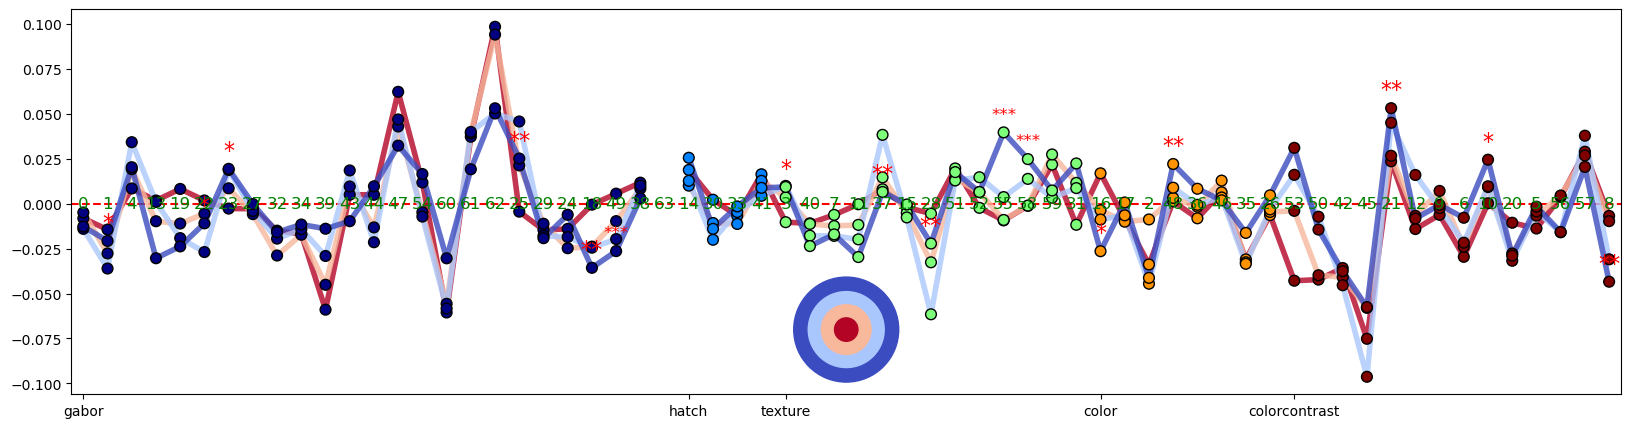

In [338]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge
import matplotlib.cm as cm
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
# 获取"rainbow"颜色映射
cmap = plt.get_cmap('coolwarm')

quater_names = [f'ecc-quater{_+1}' for _ in range(4)]
# 选择四个颜色
colors = [cmap(i) for i in np.linspace(0, 1, 4)][::-1]
for iquater, quater_name in enumerate(quater_names):
    mean_beta = np.nan * np.zeros((len(draw_sorting),))
    mean_beta[0:ecc_models[quater_name+'-w'].shape[1]] = ecc_models[quater_name+'-w'].mean(axis=0)
    mean_beta = mean_beta[np.array(draw_sorting)]
    ax.plot(mean_beta, lw=4,zorder=4, color=colors[iquater],label=f'ecc-{iquater+1}', alpha=0.8)
    ax.scatter(np.arange(len(draw_sorting)), mean_beta, color=draw_colors,s=60, edgecolors='black', zorder=5)

eccentricities = [0.25, 0.5, 0.75, 1]
ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower center')
# 画出每个圆环
for i, ecc in enumerate(eccentricities):
    inner_radius = 0 if i == 0 else eccentricities[i-1]
    outer_radius = ecc
    wedge = Wedge((0, 0), outer_radius, 0, 360, width=outer_radius-inner_radius, color=colors[i])
    ax_inset.add_patch(wedge)
ax_inset.set_xlim(-1.1, 1.1)
ax_inset.set_ylim(-1.1, 1.1)
# 设置插入圆盘的轴为等比例，隐藏坐标轴
ax_inset.set_aspect('equal')

ax_inset.axis('off')

ax.set_xlim([-0.5, 63.5])
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.axhline(y=0, color='red', ls='--')

draw_pvalues = pvalues[np.array(draw_sorting)]
posoffset =0
for pos in np.where(np.logical_and(draw_pvalues < 0.05, draw_pvalues >= 0.01)==1)[0]:
    infotxt = '*'
    ax.text(pos+posoffset, mean_beta[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='center', verticalalignment='center', zorder=7)
for pos in np.where(np.logical_and(draw_pvalues < 0.01, draw_pvalues >= 0.001)==1)[0]:
    infotxt = '**'
    ax.text(pos+posoffset, mean_beta[pos]+0.01, infotxt, fontsize=16, color='red',
    horizontalalignment='center', verticalalignment='center',zorder=7)
for pos in np.where(draw_pvalues < 0.001)[0]:
    infotxt = '***'
    ax.text(pos+posoffset, mean_beta[pos]+0.01, infotxt, fontsize=12, color='red',
    horizontalalignment='center', verticalalignment='center',zorder=7)
for _ in np.arange(64):
    ax.text(_, 0, draw_sorting[_], fontsize=12, color='green',
        horizontalalignment='center', verticalalignment='center',zorder=7)
# plt.legend()
plt.show()

24 22 17


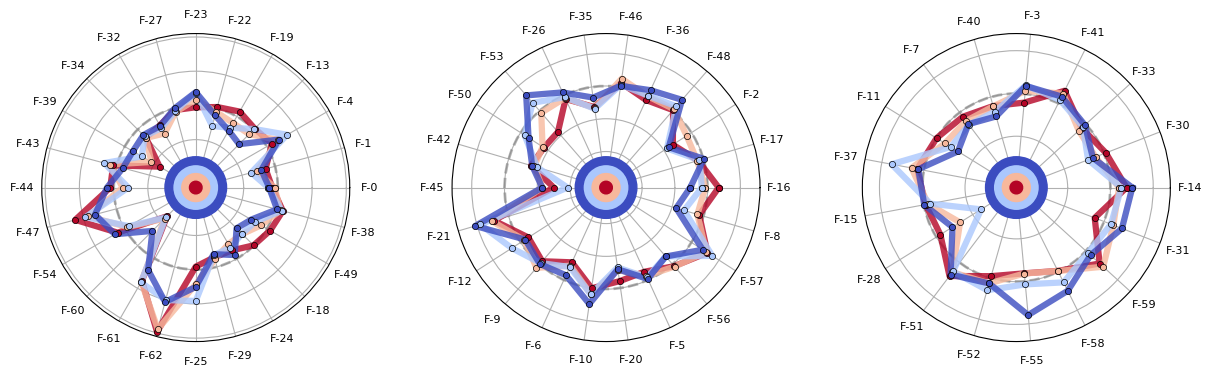

In [224]:
# 雷达图 - family-wise

fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw=dict(polar=True))

# 获取"rainbow"颜色映射
cmap = plt.get_cmap('coolwarm')

quater_names = [f'ecc-quater{_+1}' for _ in range(4)]
# 选择四个颜色
colors = [cmap(i) for i in np.linspace(0, 1, 4)][::-1]

families = [gabor_channel, color_channel, texture_channel]
for ifamily, ax in enumerate(axs):
    family_channel = families[ifamily]
    # 画gabor channel的雷达图
    labels = np.array([f"F-{i}" for i in family_channel ])  # 25个辐轴标签，使用英文

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()  # 分布在圆周上的角度
    angles += angles[:1]  # 闭合图形

    for iquater, quater_name in enumerate(quater_names):
        mean_beta = np.nan * np.zeros((len(family_channel),))
        mean_beta = ecc_models[quater_name+'-w'].mean(axis=0)[np.array(family_channel)]

        mean_beta =  np.concatenate((mean_beta,[mean_beta[0]]))
        ax.plot(angles, mean_beta, lw=4.5,zorder=4, color=colors[iquater],label=f'ecc-{iquater+1}', alpha=0.8)
        ax.scatter(angles, mean_beta, color=colors[iquater],s=20, edgecolors='black', zorder=5,lw=0.5)#
    
    lineangles = np.linspace(0, 2*np.pi, 50, endpoint=False).tolist()
    lineangles += lineangles[:1]
    ax.plot(lineangles, [0]*len(lineangles), lw=2,zorder=3, color='gray', alpha=0.6, ls='--')

    # 画 中心 legend
    inset_ax = inset_axes(ax, width="22%", height="22%", loc='center', borderpad=-2)
    inset_ax.set_aspect('equal')  # 设置等比例，确保圆形显示为圆形
    for i, ecc in enumerate(eccentricities):
        inner_radius = 0 if i == 0 else eccentricities[i-1]
        outer_radius = ecc
        wedge = Wedge((0, 0), outer_radius, 0, 360, width=outer_radius-inner_radius, color=colors[i])
        inset_ax.add_patch(wedge)
    inset_ax.set_xlim(-1.1, 1.1)
    inset_ax.set_ylim(-1.1, 1.1)
    inset_ax.axis('off')
    
    # # 添加显著性
    # if ifamily== 0:
    #     hieghtloc = 0.07
    # if ifamily==1:
    #     hieghtloc = 0.07
    # if ifamily==2:
    #     hieghtloc = 0.06
    # draw_pvalues = pvalues[np.array(family_channel)]
    # for pos in np.where(np.logical_and(draw_pvalues < 0.05, draw_pvalues >= 0.01)==1)[0]:
    #     infotxt = '*'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center', zorder=7)
    # for pos in np.where(np.logical_and(draw_pvalues < 0.01, draw_pvalues >= 0.001)==1)[0]:
    #     infotxt = '**'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center',zorder=7)
    # for pos in np.where(draw_pvalues < 0.001)[0]:
    #     infotxt = '***'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center',zorder=7)


    # 设置辐轴的标签，使用英文
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)
    if ifamily== 0:
        ax.set_ylim([-0.12, 0.105])
        ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
    if ifamily==1:
        ax.set_ylim([-0.155, 0.08])
        ax.set_yticks([-0.15, -0.1, -0.05, 0, 0.05])
    if ifamily==2:
        ax.set_ylim([-0.11, 0.07]) 
        ax.set_yticks([-0.1, -0.05, 0, 0.05])
    # ax.set_yticks([0,0.05,0.1])
    ax.set_yticklabels([])

plt.show()

In [215]:
angles

[0.0,
 0.36959913571644626,
 0.7391982714328925,
 1.1087974071493387,
 1.478396542865785,
 1.8479956785822313,
 2.2175948142986774,
 2.587193950015124,
 2.95679308573157,
 3.326392221448016,
 3.6959913571644627,
 4.065590492880909,
 4.435189628597355,
 4.804788764313801,
 5.174387900030248,
 5.543987035746694,
 5.91358617146314,
 0.0]

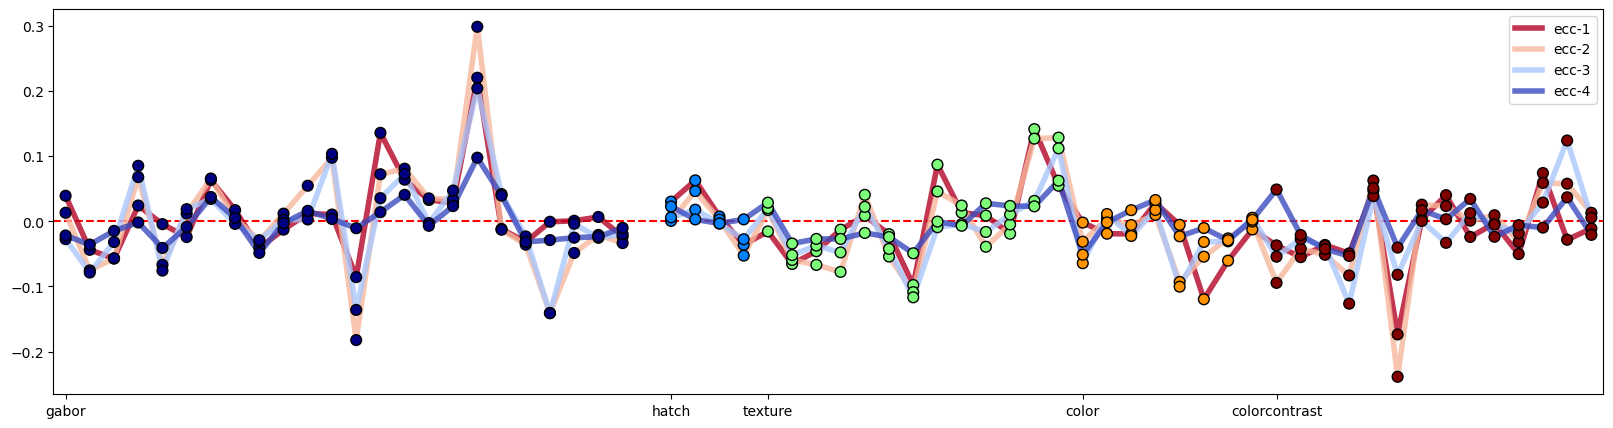

In [84]:
# 看一点单被试的情况
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
# 获取"rainbow"颜色映射
cmap = plt.get_cmap('coolwarm')

# 选择四个颜色
subidx = 1
colors = [cmap(i) for i in np.linspace(0, 1, 4)][::-1]
for iquater, quater_name in enumerate(quater_names):
    beta = np.nan * np.zeros((len(draw_sorting),))
    beta[0:ecc_models[quater_name+'-w'].shape[1]] = ecc_models[quater_name+'-w'][subidx]
    beta = beta[np.array(draw_sorting)]
    ax.plot(beta, lw=4,zorder=4, color=colors[iquater],label=f'ecc-{iquater+1}', alpha=0.8)
    ax.scatter(np.arange(len(draw_sorting)), beta, color=draw_colors,s=60, edgecolors='black', zorder=5)

ax.set_xlim([-0.5, 63.5])
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.axhline(y=0, color='red', ls='--')
plt.legend()
plt.show()

In [ ]:
# 对ecc差异做一些统计


#### 对比不同polar angle上被试平均的系数

In [298]:
# 加载不同 ang bin 被试的模型
ang_models = {}
quater_names = [f'ang-quater{_+1}' for _ in range(8)]

for quater_name in quater_names:

    quater_model_path = pjoin(work_dir, f'build/lasso-feature-withinsub-concatevoxels/{quater_name}')
    ang_models[quater_name] = sorted([pjoin(quater_model_path, _) for _ in os.listdir(quater_model_path) if 'linear' in _])
    ang_models[quater_name+'-w'] = np.array([joblib.load(model).coef_ for model in ang_models[quater_name]])

    print(ang_models[quater_name+'-w'].shape)

(9, 63)
(9, 63)
(9, 63)
(9, 63)
(9, 63)
(9, 63)
(9, 63)
(9, 63)


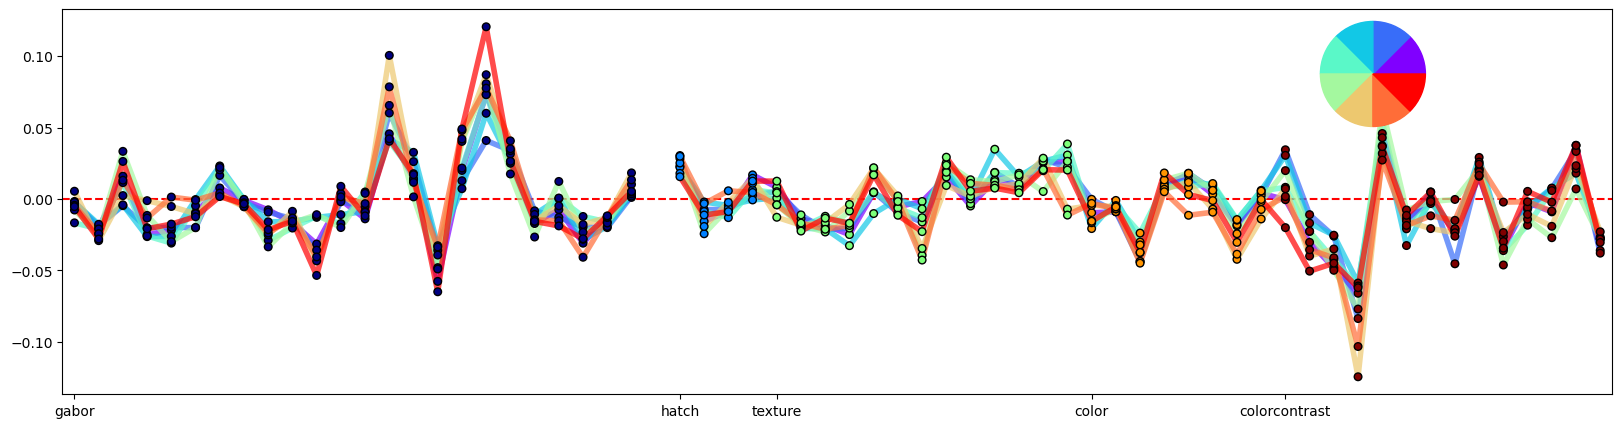

In [299]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Wedge
import matplotlib.cm as cm
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(20,5))
# 获取"rainbow"颜色映射
cmap = plt.get_cmap('rainbow')
ax_inset = inset_axes(ax, width="30%", height="30%", loc='upper right')

# 选择八个颜色
colors = [cmap(i) for i in np.linspace(0, 1, 8)]
for iquater, quater_name in enumerate(quater_names):
    mean_beta = np.nan * np.zeros((len(draw_sorting),))
    mean_beta[0:ang_models[quater_name+'-w'].shape[1]] = ang_models[quater_name+'-w'].mean(axis=0)
    mean_beta = mean_beta[np.array(draw_sorting)]
    ax.plot(mean_beta, lw=4,zorder=4, color=colors[iquater],label=f'ang-{iquater+1}', alpha=0.7)
    ax.scatter(np.arange(len(draw_sorting)), mean_beta, color=draw_colors,s=30, edgecolors='black', zorder=5)

for i in range(8):
    theta1, theta2 = i * 45, (i + 1) * 45
    wedge = Wedge((0, 0), 1, theta1, theta2, color=colors[i])
    ax_inset.add_patch(wedge)

# 设置插入圆盘的轴为等比例，隐藏坐标轴
ax_inset.set_aspect('equal')
ax_inset.set_xlim(-1.1, 1.1)
ax_inset.set_ylim(-1.1, 1.1)
ax_inset.axis('off')

ax.set_xlim([-0.5, 63.5])
ax.set_xticks(draw_ticks[0:-1])
ax.set_xticklabels(draw_tickslabels)
ax.axhline(y=0, color='red', ls='--')
# plt.legend()
plt.show()

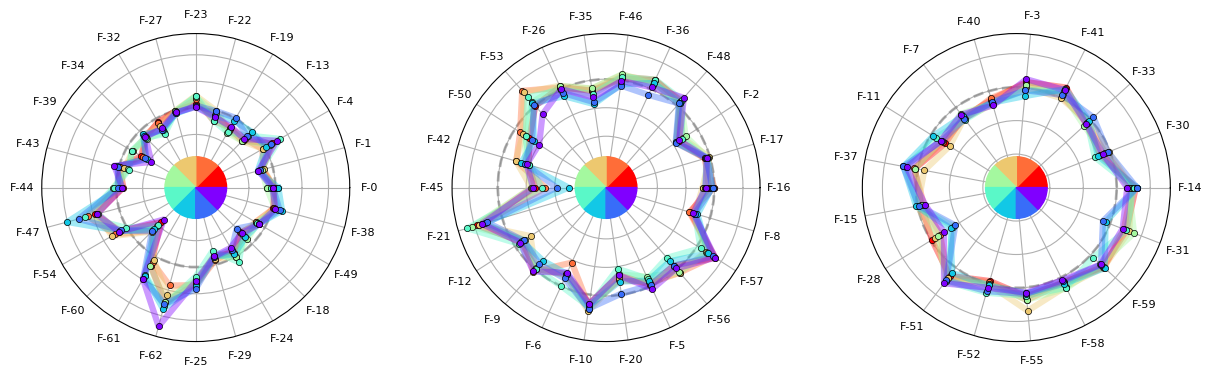

In [320]:
# 雷达图 - ang
fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw=dict(polar=True))

# 获取"rainbow"颜色映射
cmap = plt.get_cmap('rainbow')

quater_names = [f'ang-quater{_+1}' for _ in range(8)]
# 选择四个颜色
colors = [cmap(i) for i in np.linspace(0, 1, 8)][::-1]

families = [gabor_channel, color_channel, texture_channel]
for ifamily, ax in enumerate(axs):
    family_channel = families[ifamily]
    # 画gabor channel的雷达图
    labels = np.array([f"F-{i}" for i in family_channel ])  # 25个辐轴标签，使用英文

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()  # 分布在圆周上的角度
    angles += angles[:1]  # 闭合图形

    for iquater, quater_name in enumerate(quater_names):
        mean_beta = np.nan * np.zeros((len(family_channel),))
        mean_beta = ang_models[quater_name+'-w'].mean(axis=0)[np.array(family_channel)]

        mean_beta =  np.concatenate((mean_beta,[mean_beta[0]]))
        ax.plot(angles, mean_beta, lw=4.5,zorder=4, color=colors[iquater],label=f'ecc-{iquater+1}', alpha=0.4)
        ax.scatter(angles, mean_beta, color=colors[iquater],s=20, edgecolors='black', zorder=5, lw=0.5)#
    
    lineangles = np.linspace(0, 2*np.pi, 50, endpoint=False).tolist()
    lineangles += lineangles[:1]
    ax.plot(lineangles, [0]*len(lineangles), lw=2,zorder=3, color='gray', alpha=0.6, ls='--')

    # 画 中心 legend
    inset_ax = inset_axes(ax, width="22%", height="22%", loc='center', borderpad=-2)
    inset_ax.set_aspect('equal')  # 设置等比例，确保圆形显示为圆形
    for i in range(8):
        theta1, theta2 = i * 45, (i + 1) * 45
        wedge = Wedge((0, 0), 1, theta1, theta2, color=colors[i])
        inset_ax.add_patch(wedge)

    inset_ax.set_xlim(-1.1, 1.1)
    inset_ax.set_ylim(-1.1, 1.1)
    inset_ax.axis('off')
    
    # # 添加显著性
    # if ifamily== 0:
    #     hieghtloc = 0.07
    # if ifamily==1:
    #     hieghtloc = 0.07
    # if ifamily==2:
    #     hieghtloc = 0.06
    # draw_pvalues = pvalues[np.array(family_channel)]
    # for pos in np.where(np.logical_and(draw_pvalues < 0.05, draw_pvalues >= 0.01)==1)[0]:
    #     infotxt = '*'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center', zorder=7)
    # for pos in np.where(np.logical_and(draw_pvalues < 0.01, draw_pvalues >= 0.001)==1)[0]:
    #     infotxt = '**'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center',zorder=7)
    # for pos in np.where(draw_pvalues < 0.001)[0]:
    #     infotxt = '***'
    #     ax.text(angles[pos], hieghtloc, infotxt, fontsize=16, color='black',
    #     horizontalalignment='center', verticalalignment='center',zorder=7)


    # 设置辐轴的标签，使用英文
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=8)
    if ifamily== 0:
        ax.set_ylim([-0.15, 0.14])
        ax.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])
    if ifamily==1:
        ax.set_ylim([-0.19, 0.08])
        ax.set_yticks([-0.15, -0.1, -0.05, 0, 0.05])
    if ifamily==2:
        ax.set_ylim([-0.15, 0.08]) 
        ax.set_yticks([-0.1, -0.05, 0, 0.05])
    # ax.set_yticks([0,0.05,0.1])
    ax.set_yticklabels([])

plt.show()

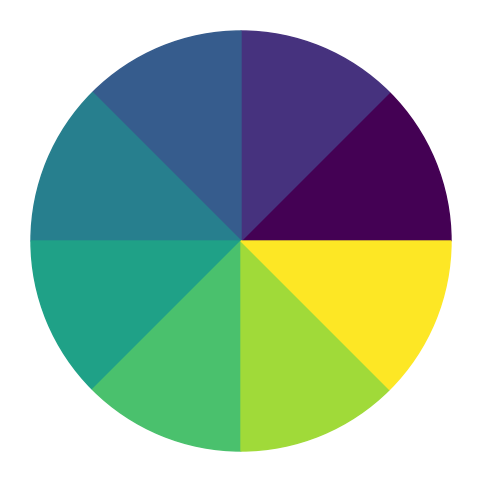

In [112]:
from matplotlib.patches import Wedge
import matplotlib.cm as cm

# 设置圆盘的部分数量和颜色
segments = 8
colors = cm.viridis(np.linspace(0, 1, segments))

# 创建图形和轴
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal')

# 画圆盘的每个部分
for i in range(segments):
    theta1 = i * (360 / segments)
    theta2 = (i + 1) * (360 / segments)
    wedge = Wedge((0, 0), 1, theta1, theta2, color=colors[i])
    ax.add_patch(wedge)

# 隐藏坐标轴
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.axis('off')

plt.show()

In [111]:
matplotlib.__version__

'3.3.2'

## check receptive field


In [56]:
mask_file_path = pjoin(work_dir, 'prep/voxel_masks')
# load mask
mask_name = 'primaryvis-in-MMP'
voxel_mask_nii = nib.load(pjoin(voxel_mask_path, f'nod-voxmask_{mask_name}.dlabel.nii'))
voxel_mask = voxel_mask_nii.get_fdata()
# squeeze into 1 dim
voxel_mask = np.squeeze(np.array(voxel_mask))
# transfer mask into indices
mask_voxel_indices = np.where(voxel_mask==1)[0]
mask_voxel_indices.shape


(4193,)

In [49]:
from utils import save2cifti
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
subs = [f'sub-0{isub+1}' for isub in range(0, 9)]
for sub in subs:
    os.makedirs(pjoin(map_dir, sub), exist_ok=True)
    prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
    sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
    named_maps = [named_map.map_name for named_map in nib.load(sub_prf_file).header.get_index_map(0).named_maps]
    # print(named_maps)
    # load and modify
    prf_data = nib.load(sub_prf_file).get_fdata()
    prf_r2 = prf_data[3,:]
    r2_thres = 10
    # make mask
    prf_voxel_mask = prf_r2 > r2_thres
    # transfer mask into indices
    voxel_indices = np.array([ _ for _ in np.where(prf_voxel_mask==1)[0] if _ in mask_voxel_indices])

    masked_prf = np.nan*np.zeros_like(prf_data)
    for irow in range(masked_prf.shape[0]):
        if irow in [named_maps.index('ecc'), named_maps.index('rfsize')] :
            masked_prf[irow, voxel_indices] = prf_data[irow,voxel_indices] * 16/200
        else:
            masked_prf[irow, voxel_indices] = prf_data[irow,voxel_indices]
    
    bfiletemplate = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/template.dtseries.nii')
    brain_models = bfiletemplate.header.get_index_map(1).brain_models
    surface_brain_models = [bm for bm in brain_models if bm.model_type == 'CIFTI_MODEL_TYPE_SURFACE']
    # print(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii'))
    save2cifti(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii'),  
                masked_prf, surface_brain_models, map_names=named_maps)

In [55]:
retino_path = pjoin(work_dir, 'build/retinoparams')
dnnprf = np.load(pjoin(retino_path, f'{sub}_layer-googlenet-conv2_params.npy'), allow_pickle=True)[0]
np.where(np.isnan(dnnprf['ecc'])!=1)[0].shape
['ang', 'ecc', 'rfsize', 'R2']

(4193,)

In [61]:
opendata_cifti_pth = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
retino_path = pjoin(work_dir, 'build/retinoparams')

map_dir = pjoin(work_dir, 'anal/brainmap/masked_retinotopy')
subs = [f'sub-0{isub+1}' for isub in range(0, 9)]
for sub in subs:
    os.makedirs(pjoin(map_dir, sub), exist_ok=True)
    prf_path = pjoin(opendata_cifti_pth, sub, 'results/ses-prf_task-prf')
    sub_prf_file = pjoin(prf_path, 'ses-prf_task-prf_params.dscalar.nii')
    named_maps = [named_map.map_name for named_map in nib.load(sub_prf_file).header.get_index_map(0).named_maps]
    # print(named_maps)
    # load and modify
    prf_r2 = nib.load(sub_prf_file).get_fdata()[3,:]
    r2_thres = 10
    # make mask
    prf_voxel_mask = prf_r2 > r2_thres

    dnnprf = np.load(pjoin(retino_path, f'{sub}_layer-googlenet-conv2_params.npy'), allow_pickle=True)[0]
    named_maps = list(dnnprf.keys())

    # transfer mask into indices
    voxel_indices = np.array([ _ for _ in np.where(prf_voxel_mask==1)[0] if _ in mask_voxel_indices])

    full_prf = np.nan*np.zeros((4, 59412))
    for irow, indexname in enumerate(named_maps):
        full_prf[irow, mask_voxel_indices] = dnnprf[indexname][mask_voxel_indices]
    
    bfiletemplate = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/template.dtseries.nii')
    brain_models = bfiletemplate.header.get_index_map(1).brain_models
    surface_brain_models = [bm for bm in brain_models if bm.model_type == 'CIFTI_MODEL_TYPE_SURFACE']
    # print(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii'))
    save2cifti(pjoin(map_dir, sub, f'{sub}_dnn-prf.dscalar.nii'),  
                full_prf, surface_brain_models, map_names=named_maps)

    # masked_prf = np.nan*np.zeros((4, 59412))
    # for irow, indexname in enumerate(named_maps):
    #     masked_prf[irow, voxel_indices] = dnnprf[indexname][voxel_indices]
    
    # bfiletemplate = nib.load('/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/template.dtseries.nii')
    # brain_models = bfiletemplate.header.get_index_map(1).brain_models
    # surface_brain_models = [bm for bm in brain_models if bm.model_type == 'CIFTI_MODEL_TYPE_SURFACE']
    # # print(pjoin(map_dir, sub, f'{sub}_masked-prior-prf.dscalar.nii'))
    # save2cifti(pjoin(map_dir, sub, f'{sub}_masked-dnn-prf.dscalar.nii'),  
    #             masked_prf, surface_brain_models, map_names=named_maps)